In [1]:
## Major parameters for later analysis
window = 25 # moving window
length = 180 # length of time in each segment in minutes, 6 hours = 360 minutes, 3 hours = 180 minutes

# Data import and exploration

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import pandas as pd
import csv
import io
import datetime
from sklearn import cluster
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.manifold import MDS
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from tslearn.metrics import cdist_dtw, dtw
from tslearn.clustering import TimeSeriesKMeans

%matplotlib inline
# below makes plot generation super slow - use at own risk
# plt.rcParams['text.usetex'] = True
# plt.rcParams['pdf.fonttype'] = 42
# plt.rcParams['ps.fonttype'] = 42

In [3]:
filenames = [
    "001__Created_09Aug2021@1640.csv", 
    "001__Created_09Aug2021@1650.csv", 
    "002__Created_12Aug2021@1627.csv",
    "003__Created_12Aug2021@1634.csv",
    "004__Created_12Aug2021@1639.csv",
    "004__Created_12Aug2021@1642.csv",
    "005__Created_12Aug2021@1647.csv",
    "006__Created_12Aug2021@1649.csv",
    "007__Created_12Aug2021@1655.csv",
    "008__Created_12Aug2021@1700.csv"
]

In [4]:
dfs_raw = [] # we won't change this - for raw data comparison
for file in filenames:
    f = pd.read_csv(file, sep=',', header=0, index_col=0)
    dfs_raw.append(f)

In [5]:
dfs_raw[0].head(15)

,LifetouchHeartRate,LifetouchRespirationRate,LifetouchPatientOrientation,LifetempTemperature,OximeterSpO2,OximeterPulse,EarlyWarningScore,EarlyWarningMax
Timestamp_GMTStandardTime_,,,,,,,,
5/5/2021 7:00,NaN,NaN,NaN,30.8,94.0,101.0,NaN,NaN
5/5/2021 7:01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5/5/2021 7:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5/5/2021 7:03,NaN,NaN,NaN,31.8,NaN,NaN,NaN,NaN
5/5/2021 7:04,87.0,20.0,NaN,32.1,NaN,NaN,NaN,NaN
5/5/2021 7:05,85.0,19.0,NaN,32.8,NaN,NaN,NaN,NaN
5/5/2021 7:06,89.0,17.0,NaN,32.3,NaN,NaN,NaN,NaN
5/5/2021 7:07,87.0,14.0,NaN,32.7,NaN,NaN,NaN,NaN
5/5/2021 7:08,90.0,15.0,NaN,33.0,NaN,NaN,NaN,NaN


In [6]:
for df in dfs_raw:
    print(df.shape)


(1463, 8)
(40360, 8)
(1328, 8)
(33131, 8)
(10253, 8)
(41817, 8)
(30316, 8)
(22860, 8)
(49072, 8)
(50095, 8)


In [7]:
# NaN remaining values that are clearly error codes, in this case greater than 500
for df in dfs_raw:
    df.where(df[['LifetouchHeartRate', 'LifetouchRespirationRate', 'LifetempTemperature']] < 500, np.NaN, inplace=True)
dfs_raw[0].head(15)   

,LifetouchHeartRate,LifetouchRespirationRate,LifetouchPatientOrientation,LifetempTemperature,OximeterSpO2,OximeterPulse,EarlyWarningScore,EarlyWarningMax
Timestamp_GMTStandardTime_,,,,,,,,
5/5/2021 7:00,NaN,NaN,NaN,30.8,94.0,101.0,NaN,NaN
5/5/2021 7:01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5/5/2021 7:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5/5/2021 7:03,NaN,NaN,NaN,31.8,NaN,NaN,NaN,NaN
5/5/2021 7:04,87.0,20.0,NaN,32.1,NaN,NaN,NaN,NaN
5/5/2021 7:05,85.0,19.0,NaN,32.8,NaN,NaN,NaN,NaN
5/5/2021 7:06,89.0,17.0,NaN,32.3,NaN,NaN,NaN,NaN
5/5/2021 7:07,87.0,14.0,NaN,32.7,NaN,NaN,NaN,NaN
5/5/2021 7:08,90.0,15.0,NaN,33.0,NaN,NaN,NaN,NaN


In [8]:
# rename toy data columns to reflect real data, for code reusability

for df in dfs_raw: 
    df.columns = ['Lifetouch Heart Rate', 'Lifetouch Respiration Rate',
       'Lifetouch Patient Orientation', 'Lifetemp Temperature', 'Oximeter SpO2',
       'Oximeter Pulse', 'Early Warning Score', 'Early Warning Max']

## How much non-NaN data do we have?

In [9]:
total_readings = 0
cumulative_reading_time = 0
min_recording_time = 999
max_recording_time = 0
patient_list = [1, 1, 2, 3, 4, 4, 5, 6, 7, 8]

for j, df in enumerate(dfs_raw):
    print(f"\nPatient {patient_list[j]} (file {j})")
    print(f"Total length: {df.shape[0]}")
    print(f"Total entries with at least one reading: {df.dropna(how='all').shape[0]}, "
          f"equivalent to {df.dropna(how='all').shape[0]/60:.2f} hours")
    
    total_readings += df.dropna(how='all').shape[0] # only drop row if it has zero readings 
    reading_time = df.index.get_loc(df.notna()[::-1].idxmax().max()) - df.index.get_loc(df.notna().idxmax().min()) + 1
        # last entry index - first entry index
    if reading_time < min_recording_time:
        min_recording_time = reading_time 
    if reading_time > max_recording_time:
        max_recording_time = reading_time
    print(f"Length of time between first and last reading: {reading_time/60:.2f} hours")
    cumulative_reading_time += reading_time
    
    # iterate over columns (in order of table in paper)
    for i in ['Lifetouch Heart Rate', 'Lifetouch Respiration Rate', 'Lifetemp Temperature', 'Oximeter SpO2', 'Oximeter Pulse']:
        first_idx = df.notna().idxmax()[i]
        last_idx = df.notna()[::-1].idxmax()[i]
        print(f"   {i} hours: {df.count()[i]/60:.2f}")

print(f"\n Total readings: {total_readings/60:.2f} over {cumulative_reading_time/60:.2f} hours " + 
     f"(Range: {min_recording_time:.0f} minutes to {max_recording_time/60:.2f} hours.)")



Patient 1 (file 0)
Total length: 1463
Total entries with at least one reading: 94, equivalent to 1.57 hours
Length of time between first and last reading: 24.38 hours
   Lifetouch Heart Rate hours: 0.62
   Lifetouch Respiration Rate hours: 0.62
   Lifetemp Temperature hours: 1.57
   Oximeter SpO2 hours: 0.02
   Oximeter Pulse hours: 0.02

Patient 1 (file 1)
Total length: 40360
Total entries with at least one reading: 9511, equivalent to 158.52 hours
Length of time between first and last reading: 672.67 hours
   Lifetouch Heart Rate hours: 145.57
   Lifetouch Respiration Rate hours: 145.57
   Lifetemp Temperature hours: 152.78
   Oximeter SpO2 hours: 10.38
   Oximeter Pulse hours: 10.38

Patient 2 (file 2)
Total length: 1328
Total entries with at least one reading: 139, equivalent to 2.32 hours
Length of time between first and last reading: 2.32 hours
   Lifetouch Heart Rate hours: 2.30
   Lifetouch Respiration Rate hours: 2.30
   Lifetemp Temperature hours: 2.32
   Oximeter SpO2 hours

In [10]:
# patient 1 descriptive stats combined
print(f"\nPatient 1 (files 1 and 2)")
df1_merged = dfs_raw[0].append(dfs_raw[1])
print(f"Total length: {df1_merged.shape[0]}")
print(f"Total entries with at least one reading: {df1_merged.dropna(how='all').shape[0]}, "
      f"equivalent to {df1_merged.dropna(how='all').shape[0]/60:.2f} hours")

reading_time = (df1_merged.index.get_loc(df1_merged.notna()[::-1].idxmax().max()) - 
        df1_merged.index.get_loc(df1_merged.notna().idxmax().min()) + 1)
print(f"Length of time between first and last reading: {reading_time/60:.2f} hours")
for i in ['Lifetouch Heart Rate', 'Lifetouch Respiration Rate', 'Lifetemp Temperature', 'Oximeter SpO2', 'Oximeter Pulse']:
        first_idx = df1_merged.notna().idxmax()[i]
        last_idx = df1_merged.notna()[::-1].idxmax()[i]
        print(f"   {i} hours: {df1_merged.count()[i]/60:.2f}")

# patient 4  descriptive stats combined
print(f"\nPatient 4 (files 4 and 5)")
df4_merged = dfs_raw[4].append(dfs_raw[5])
print(f"Total length: {df4_merged.shape[0]}")
print(f"Total entries with at least one reading: {df4_merged.dropna(how='all').shape[0]}, "
      f"equivalent to {df4_merged.dropna(how='all').shape[0]/60:.2f} hours")

reading_time = (df4_merged.index.get_loc(df4_merged.notna()[::-1].idxmax().max()) - 
        df4_merged.index.get_loc(df4_merged.notna().idxmax().min()) + 1)
print(f"Length of time between first and last reading: {reading_time/60:.2f} hours")
for i in ['Lifetouch Heart Rate', 'Lifetouch Respiration Rate', 'Lifetemp Temperature', 'Oximeter SpO2', 'Oximeter Pulse']:
        first_idx = df4_merged.notna().idxmax()[i]
        last_idx = df4_merged.notna()[::-1].idxmax()[i]
        print(f"   {i} hours: {df4_merged.count()[i]/60:.2f}")


Patient 1 (files 1 and 2)
Total length: 41823
Total entries with at least one reading: 9605, equivalent to 160.08 hours
Length of time between first and last reading: 697.05 hours
   Lifetouch Heart Rate hours: 146.18
   Lifetouch Respiration Rate hours: 146.18
   Lifetemp Temperature hours: 154.35
   Oximeter SpO2 hours: 10.40
   Oximeter Pulse hours: 10.40

Patient 4 (files 4 and 5)
Total length: 52070
Total entries with at least one reading: 18430, equivalent to 307.17 hours
Length of time between first and last reading: 867.83 hours
   Lifetouch Heart Rate hours: 300.08
   Lifetouch Respiration Rate hours: 300.08
   Lifetemp Temperature hours: 106.90
   Oximeter SpO2 hours: 1.67
   Oximeter Pulse hours: 1.67


In [11]:
# a more granular view at percentage of non-NaN values within recording intervals for each measurement
for j, df in enumerate(dfs_raw):
    print(f"\nFile {j}")
    print(f"Total length: {df.shape[0]}")
    print(f"Entries with 3 valid readings: {df.dropna().shape[0]}")
    print(f"Entries with 2 valid readings: {df[['Lifetouch Heart Rate', 'Lifetouch Respiration Rate']].dropna().shape[0]}")
    for i in range(df.shape[1]): # iterate over columns
        first_idx = df.notna().idxmax()[i]
        last_idx = df.notna()[::-1].idxmax()[i]
        print(f"   {df.columns[i]} trimmed hours: {df[first_idx:last_idx].shape[0]/60:.2f}")
        print(f"          Non-NaN values: {df.count()[i]}")
        print(f"          Percent non-NaN: {df.count()[i]/df[first_idx:last_idx].shape[0]*100:.2f}") # from trimmed
    


File 0
Total length: 1463
Entries with 3 valid readings: 0
Entries with 2 valid readings: 37
   Lifetouch Heart Rate trimmed hours: 0.62
          Non-NaN values: 37
          Percent non-NaN: 100.00
   Lifetouch Respiration Rate trimmed hours: 0.62
          Non-NaN values: 37
          Percent non-NaN: 100.00
   Lifetouch Patient Orientation trimmed hours: 24.38
          Non-NaN values: 0
          Percent non-NaN: 0.00
   Lifetemp Temperature trimmed hours: 1.60
          Non-NaN values: 94
          Percent non-NaN: 97.92
   Oximeter SpO2 trimmed hours: 0.02
          Non-NaN values: 1
          Percent non-NaN: 100.00
   Oximeter Pulse trimmed hours: 0.02
          Non-NaN values: 1
          Percent non-NaN: 100.00
   Early Warning Score trimmed hours: 24.38
          Non-NaN values: 0
          Percent non-NaN: 0.00
   Early Warning Max trimmed hours: 24.38
          Non-NaN values: 0
          Percent non-NaN: 0.00

File 1
Total length: 40360
Entries with 3 valid readings: 0


          Percent non-NaN: 1.33
   Early Warning Score trimmed hours: 817.87
          Non-NaN values: 0
          Percent non-NaN: 0.00
   Early Warning Max trimmed hours: 817.87
          Non-NaN values: 0
          Percent non-NaN: 0.00

File 9
Total length: 50095
Entries with 3 valid readings: 0
Entries with 2 valid readings: 9349
   Lifetouch Heart Rate trimmed hours: 161.88
          Non-NaN values: 9349
          Percent non-NaN: 96.25
   Lifetouch Respiration Rate trimmed hours: 161.88
          Non-NaN values: 9349
          Percent non-NaN: 96.25
   Lifetouch Patient Orientation trimmed hours: 834.92
          Non-NaN values: 0
          Percent non-NaN: 0.00
   Lifetemp Temperature trimmed hours: 257.55
          Non-NaN values: 15417
          Percent non-NaN: 99.77
   Oximeter SpO2 trimmed hours: 149.03
          Non-NaN values: 47
          Percent non-NaN: 0.53
   Oximeter Pulse trimmed hours: 149.03
          Non-NaN values: 47
          Percent non-NaN: 0.53
   Early W

### Let's get rid of some useless columns
Drop `LifetouchPatientOrientation`, `EarlyWarningScore`, `EarlyWarningMax`. (Optionally `OximeterSpO2` and `OximeterPulse` as well.) 

Ended up also removing `LifetempTemperature`, as it's so variable that it just adds noise to the data.

In [12]:
dfs_raw[1]["Lifetemp Temperature"].dropna()

Timestamp_GMTStandardTime_
5/23/2021 0:29     30.4
5/23/2021 0:30     30.5
5/23/2021 0:31     30.7
5/23/2021 0:32     30.6
5/23/2021 3:24     30.7
                   ... 
5/29/2021 19:54    31.2
5/29/2021 19:55    31.2
5/29/2021 19:56    31.4
5/29/2021 19:57    31.4
5/29/2021 19:58    30.7
Name: Lifetemp Temperature, Length: 9167, dtype: float64

Percentage of values below 34C: 20.81%


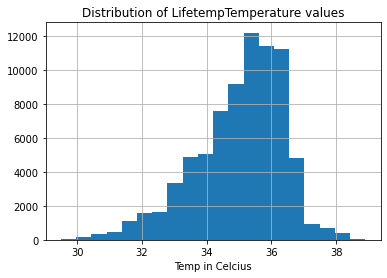

In [13]:
# let's plot the distribution of temperature data - if many values are implausible,
# we can justify excluding this measurement
temperatures = pd.concat([df["Lifetemp Temperature"] for df in dfs_raw])
temperatures.dropna(inplace=True)

# check % of values below a minimum plausible temperature
threshold = 34 
pct = temperatures.where(temperatures < threshold).count()/temperatures.count()*100
print(f"Percentage of values below {threshold}C: {pct:.2f}%")
temperatures.hist(bins=20)
plt.title('Distribution of LifetempTemperature values')
plt.xlabel('Temp in Celcius')
plt.show()

In [14]:
dfs = [] # the data we'll use for the rest of the notebook
for df in dfs_raw:
    dfs.append(df.drop([
        'Lifetouch Patient Orientation', 
        'Lifetemp Temperature',
        'Oximeter SpO2', 
        'Oximeter Pulse', 
        'Early Warning Score',
        'Early Warning Max'
    ], axis=1))

# Remaining data overview

In [15]:
j = 0
for df in dfs:
    print(f"\nFile {j}")
    print(f"Total length: {df.shape[0]}")
    for i in range(df.shape[1]): # iterate over columns
        first_idx = df.notna().idxmax()[i]
        last_idx = df.notna()[::-1].idxmax()[i]
        print(f"   {df.columns[i]} trimmed: {df[first_idx:last_idx].shape[0]}")
        print(f"          Non-NaN values: {df.count()[i]}")
        print(f"          Percent non-NaN: {df.count()[i]/df[first_idx:last_idx].shape[0]*100:.2f}") #from trimmed
    
    j+=1


File 0
Total length: 1463
   Lifetouch Heart Rate trimmed: 37
          Non-NaN values: 37
          Percent non-NaN: 100.00
   Lifetouch Respiration Rate trimmed: 37
          Non-NaN values: 37
          Percent non-NaN: 100.00

File 1
Total length: 40360
   Lifetouch Heart Rate trimmed: 9869
          Non-NaN values: 8734
          Percent non-NaN: 88.50
   Lifetouch Respiration Rate trimmed: 9869
          Non-NaN values: 8734
          Percent non-NaN: 88.50

File 2
Total length: 1328
   Lifetouch Heart Rate trimmed: 138
          Non-NaN values: 138
          Percent non-NaN: 100.00
   Lifetouch Respiration Rate trimmed: 138
          Non-NaN values: 138
          Percent non-NaN: 100.00

File 3
Total length: 33131
   Lifetouch Heart Rate trimmed: 139
          Non-NaN values: 123
          Percent non-NaN: 88.49
   Lifetouch Respiration Rate trimmed: 139
          Non-NaN values: 123
          Percent non-NaN: 88.49

File 4
Total length: 10253
   Lifetouch Heart Rate trimmed: 3

### Plot all the data for all patients

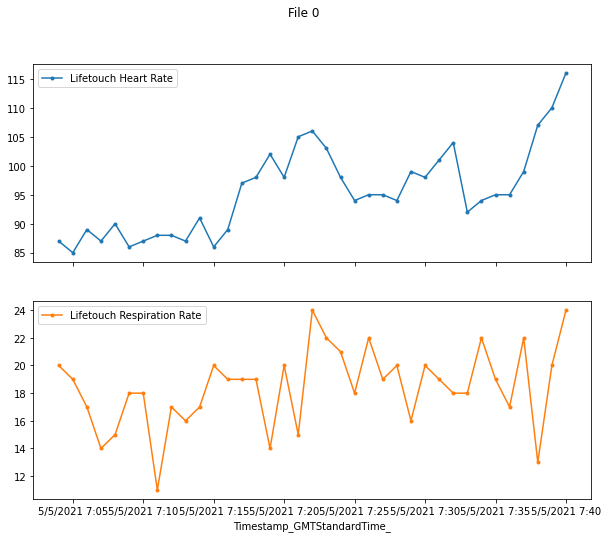

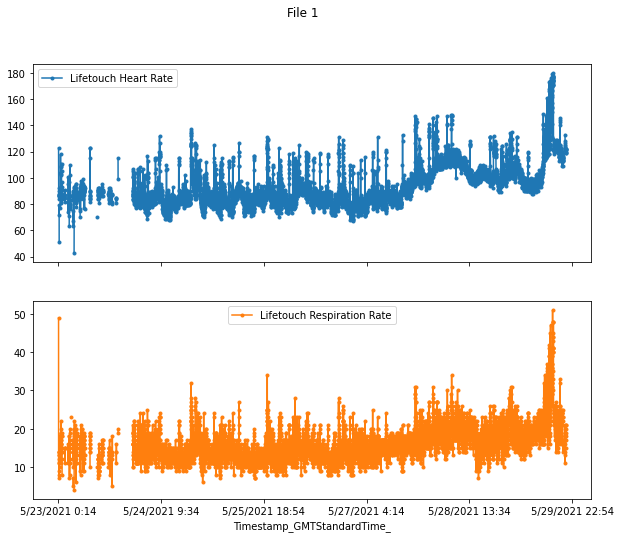

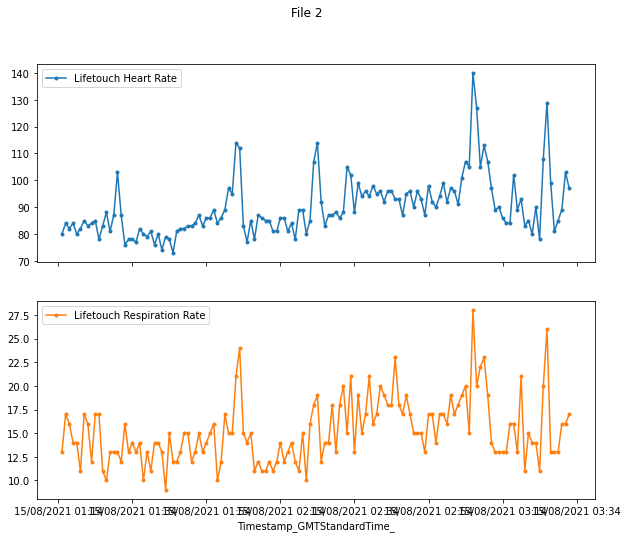

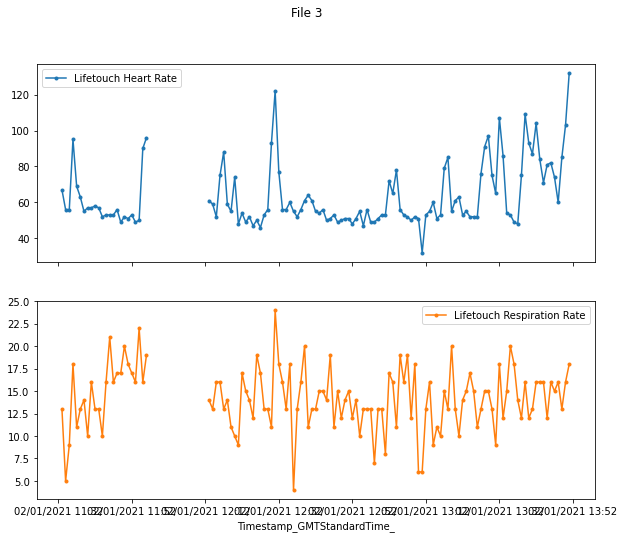

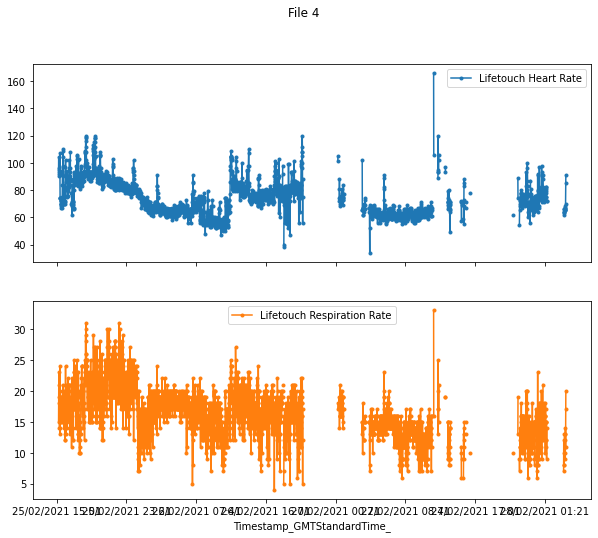

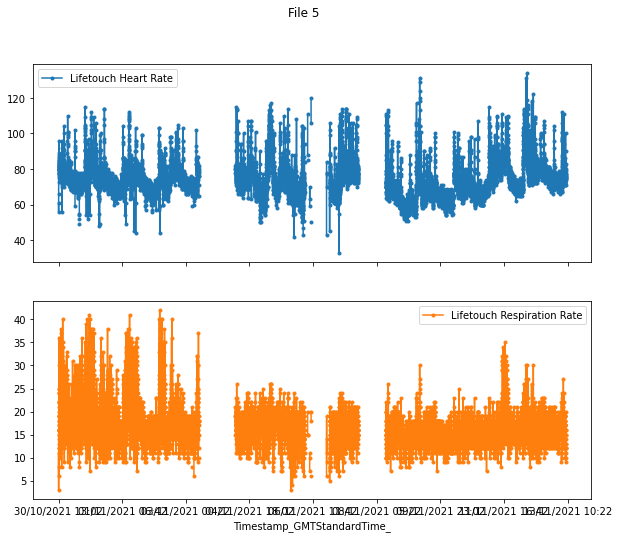

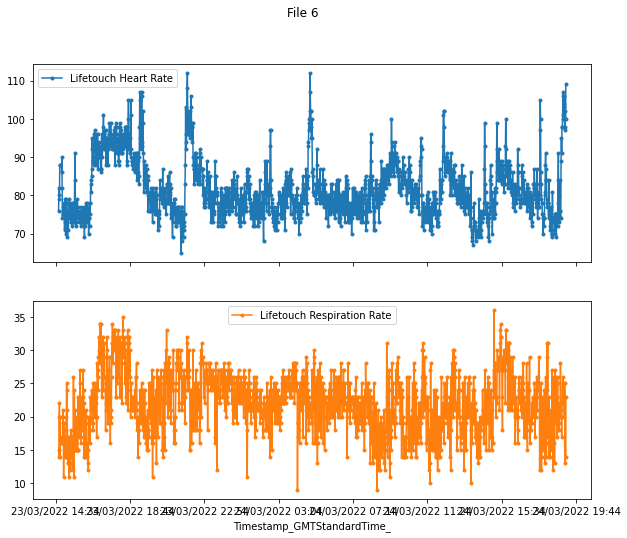

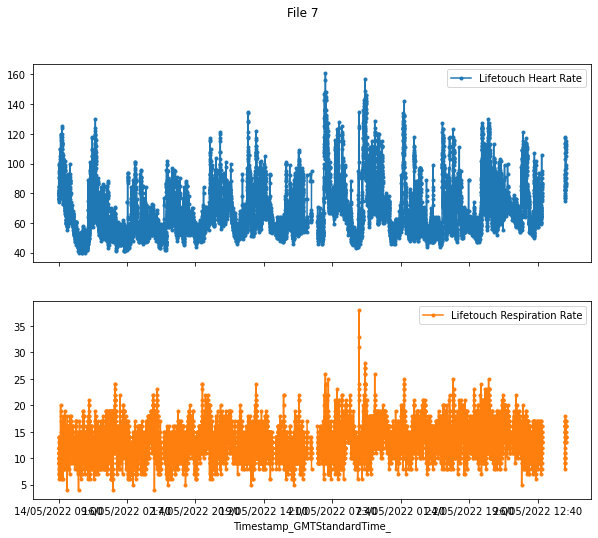

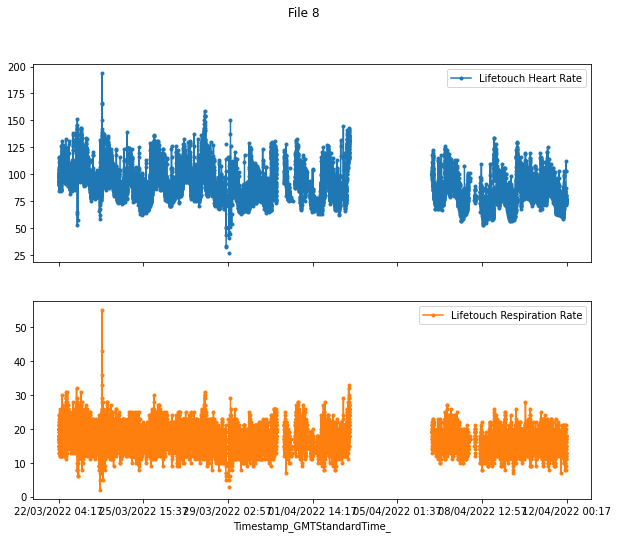

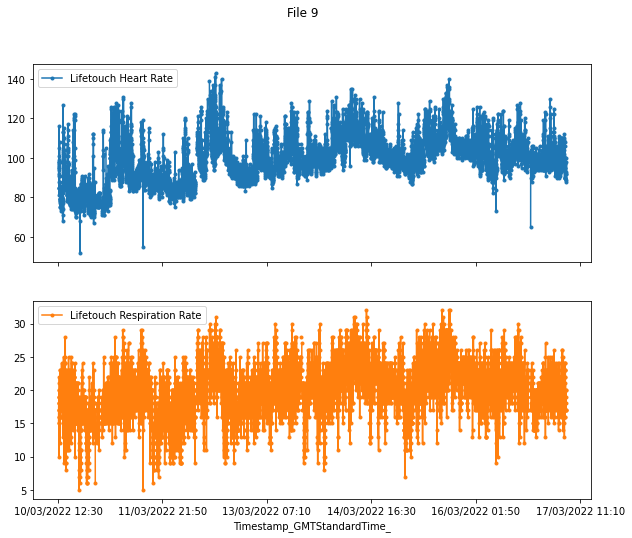

In [16]:
for i in range(len(dfs)):
    dfs[i].plot(subplots=True, style='.-', figsize=(10,8), title=("File " + str(i)))

### Plot 12 hours of data for one patient

array([<AxesSubplot:xlabel='Timestamp_GMTStandardTime_'>,
       <AxesSubplot:xlabel='Timestamp_GMTStandardTime_'>], dtype=object)

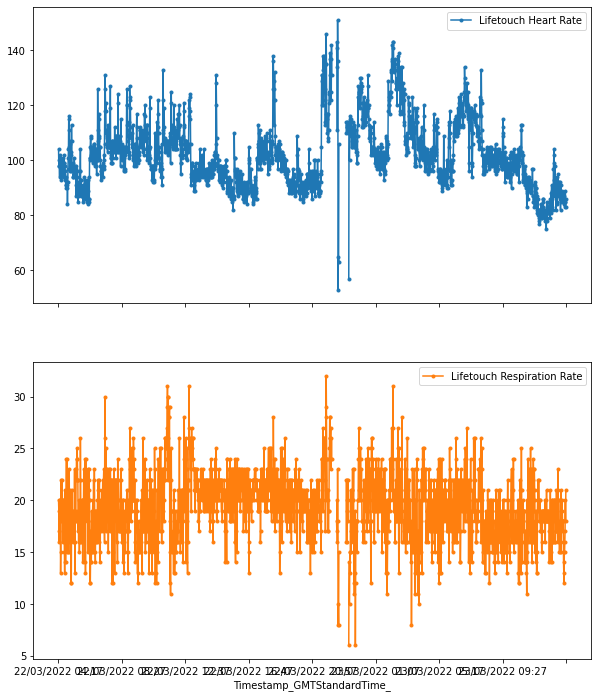

In [17]:
# starts at 0700, 12 hours should be 1900
# by location 12*60 = 720
# possible to interpolate idx 1 and 8 files
# splines?
dfs[8].iloc[:2000].plot(subplots=True, style='.-', figsize=(10,12))

In [18]:
# dfs[8]['LifetouchHeartRate'].plot(style='.-')

### Some stats

In [19]:
for df in dfs:
    print(f'mean: {df.mean(skipna=True)} \n std: {df.std(skipna=True)}')
    cov = ((df['Lifetouch Heart Rate'] - df['Lifetouch Heart Rate'].mean()) * \
        (df['Lifetouch Respiration Rate'] - df['Lifetouch Respiration Rate'].mean())).sum() / (df.shape[0]-1)
    print(f'Covariance: {cov} \n')

mean: Lifetouch Heart Rate          95.540541
Lifetouch Respiration Rate    18.432432
dtype: float64 
 std: Lifetouch Heart Rate          7.570390
Lifetouch Respiration Rate    2.911095
dtype: float64
Covariance: 0.16439900913225128 

mean: Lifetouch Heart Rate          93.561827
Lifetouch Respiration Rate    16.102473
dtype: float64 
 std: Lifetouch Heart Rate          15.420307
Lifetouch Respiration Rate     4.322021
dtype: float64
Covariance: 10.994825553889472 

mean: Lifetouch Heart Rate          89.884058
Lifetouch Respiration Rate    15.224638
dtype: float64 
 std: Lifetouch Heart Rate          10.899724
Lifetouch Respiration Rate     3.383123
dtype: float64
Covariance: 2.793966995402073 

mean: Lifetouch Heart Rate          63.016260
Lifetouch Respiration Rate    14.170732
dtype: float64 
 std: Lifetouch Heart Rate          17.526553
Lifetouch Respiration Rate     3.477580
dtype: float64
Covariance: 0.04599029690870406 

mean: Lifetouch Heart Rate          73.820615
Lifetouch R

# Analysis

### Normalize the data

In [20]:
normalized_dfs = []
for df in dfs:
    ndf = (df - df.mean(skipna=True))/df.std(skipna=True)
    normalized_dfs.append(ndf)
    print(pd.DataFrame(ndf).cov())

#patient1_1_normalized = (dfs[0] - dfs[0].mean(skipna=True))/dfs[0].std(skipna=True)
normalized_dfs[0].head(10)

                            Lifetouch Heart Rate  Lifetouch Respiration Rate
Lifetouch Heart Rate                    1.000000                    0.302949
Lifetouch Respiration Rate              0.302949                    1.000000
                            Lifetouch Heart Rate  Lifetouch Respiration Rate
Lifetouch Heart Rate                    1.000000                    0.762404
Lifetouch Respiration Rate              0.762404                    1.000000
                            Lifetouch Heart Rate  Lifetouch Respiration Rate
Lifetouch Heart Rate                    1.000000                    0.733903
Lifetouch Respiration Rate              0.733903                    1.000000
                            Lifetouch Heart Rate  Lifetouch Respiration Rate
Lifetouch Heart Rate                    1.000000                    0.204906
Lifetouch Respiration Rate              0.204906                    1.000000
                            Lifetouch Heart Rate  Lifetouch Respiration Rate

,Lifetouch Heart Rate,Lifetouch Respiration Rate
Timestamp_GMTStandardTime_,,
5/5/2021 7:00,NaN,NaN
5/5/2021 7:01,NaN,NaN
5/5/2021 7:02,NaN,NaN
5/5/2021 7:03,NaN,NaN
5/5/2021 7:04,-1.128151,0.538480
5/5/2021 7:05,-1.392338,0.194967
5/5/2021 7:06,-0.863963,-0.492060
5/5/2021 7:07,-1.128151,-1.522600
5/5/2021 7:08,-0.731870,-1.179086


### Smooth the data

Median filter (what window size is good here?)

Using https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rolling.html

In [21]:
# window is set at top but can also set here...
# window=25
use_center=False
smoothed_dfs = []
# places in rightmost position in window, alternately can set center=True

for df in normalized_dfs:
    smoothed_dfs.append(df.rolling(window=window, center=use_center).median())
smoothed_dfs[0].head(5)

,Lifetouch Heart Rate,Lifetouch Respiration Rate
Timestamp_GMTStandardTime_,,
5/5/2021 7:00,NaN,NaN
5/5/2021 7:01,NaN,NaN
5/5/2021 7:02,NaN,NaN
5/5/2021 7:03,NaN,NaN
5/5/2021 7:04,NaN,NaN


In [22]:
# compare to similar plots above
# smoothed_dfs[8].iloc[:720].plot(subplots=True, style='.-', figsize=(10,12))

### Partition the data
Split the patient's data into equal size segments. I do this by taking the floor of the number of entries divided by 720 (minutes in 12 hours), so that each partition is $12 \leq t < 13$ hours long. This ensures the splits are of equal length for each patient, but if we want them all to be exactly 12 hours long (with the final partition holding the remainder), I need to change this method.

Another thing to consider: if there are large chunks of NaNs, should we simply exclude these segments before partitioning? What's considered a segment of missing data? Is there a way to determine this algorithmically, or should we just look at the data for each patient?

In [23]:
for df in smoothed_dfs:
    print(df.shape)

(1463, 2)
(40360, 2)
(1328, 2)
(33131, 2)
(10253, 2)
(41817, 2)
(30316, 2)
(22860, 2)
(49072, 2)
(50095, 2)


In [24]:
# Remove leading and trailing NaNs in all columns 
# basically, find the earliest timestep with an entry, and remove 
# all timesteps before then from the array.

for i in range(len(smoothed_dfs)):
    first_entry = smoothed_dfs[i].notna().idxmax().min()
    last_entry = smoothed_dfs[i].notna()[::-1].idxmax().max()
    smoothed_dfs[i] = smoothed_dfs[i].loc[first_entry:last_entry]

array([<AxesSubplot:xlabel='Timestamp_GMTStandardTime_'>,
       <AxesSubplot:xlabel='Timestamp_GMTStandardTime_'>], dtype=object)

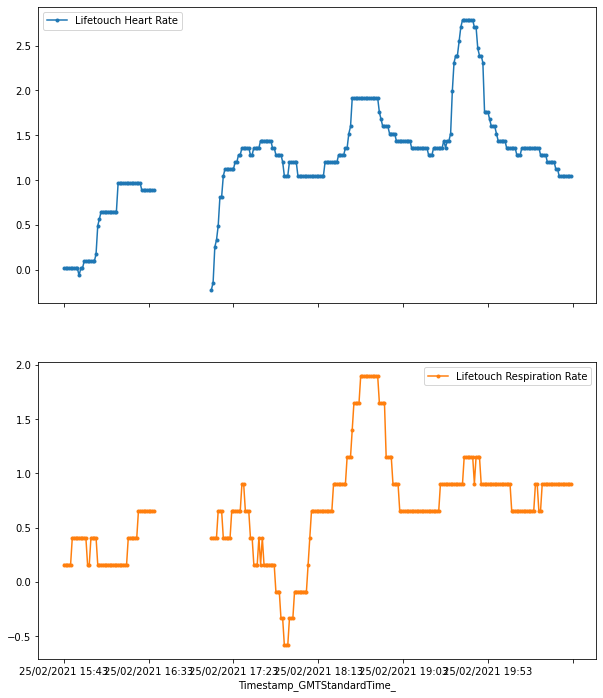

In [25]:
smoothed_dfs[4].iloc[:300].plot(subplots=True, style='.-', figsize=(10,12))

In [26]:
data = smoothed_dfs[4]
first_idx = data.notna().idxmax()
last_idx = data.notna()[::-1].idxmax()
print(" ----- First entries: ------")
print(first_idx)
print("------ Last entries: -------")
print(last_idx)
print("")

for i in range(data.shape[1]):
    print(f"{data.columns[i]} trimmed: {data[first_idx[i]:last_idx[i]].shape[0]}")
    print(f"Non-NaN values: {data.count()[i]}")
# print(f"          Percent non-NaN: {df.count()[i]/df[first_idx:last_idx].shape[0]*100:.2f}") #from trimmed

print("")
print(f"Entries with {smoothed_dfs[0].shape[1]} valid readings: {data.dropna().shape[0]}")

 ----- First entries: ------
Lifetouch Heart Rate          25/02/2021 15:43
Lifetouch Respiration Rate    25/02/2021 15:43
dtype: object
------ Last entries: -------
Lifetouch Heart Rate          28/02/2021 01:34
Lifetouch Respiration Rate    28/02/2021 01:34
dtype: object

Lifetouch Heart Rate trimmed: 3472
Non-NaN values: 2216
Lifetouch Respiration Rate trimmed: 3472
Non-NaN values: 2216

Entries with 2 valid readings: 2216


In [27]:
def find_valid_intervals(data): 
    # Find rows with any NaN values, create as mask
    # add leading and trailing buffer so we can compare to the next row sequentially
    mask = np.concatenate(( [True], data.isna().any(axis=1).to_numpy(), [True] ))

    # get start and stop limits, reshape them into array of (start, stop) pairs
    ss = np.flatnonzero(mask[1:] != mask[:-1]).reshape(-1,2) 
    return(ss)

In [28]:
# verify above method works on all dfs compared to dropna() count
for idx, df in enumerate(smoothed_dfs):
    print(f"--------- File {idx} ---------")
    ss = find_valid_intervals(df)
    print(f"Longest interval: {(ss[:,1] - ss[:,0]).max()}")
    print(f"Sum of valid entries across all intervals: {(ss[:,1] - ss[:,0]).sum()}")
    print(f"Entries with {smoothed_dfs[0].shape[1]} valid readings: {df.dropna().shape[0]}")

--------- File 0 ---------
Longest interval: 13
Sum of valid entries across all intervals: 13
Entries with 2 valid readings: 13
--------- File 1 ---------
Longest interval: 3225
Sum of valid entries across all intervals: 8343
Entries with 2 valid readings: 8343
--------- File 2 ---------
Longest interval: 114
Sum of valid entries across all intervals: 114
Entries with 2 valid readings: 114
--------- File 3 ---------
Longest interval: 75
Sum of valid entries across all intervals: 75
Entries with 2 valid readings: 75
--------- File 4 ---------
Longest interval: 1492
Sum of valid entries across all intervals: 2216
Entries with 2 valid readings: 2216
--------- File 5 ---------
Longest interval: 2609
Sum of valid entries across all intervals: 13270
Entries with 2 valid readings: 13270
--------- File 6 ---------
Longest interval: 1672
Sum of valid entries across all intervals: 1672
Entries with 2 valid readings: 1672
--------- File 7 ---------
Longest interval: 2681
Sum of valid entries acro

In [29]:
# length parameter is length of interval in minutes
def split_into_intervals(data, length=720, idx=None):
    # initialize list into which we'll put the split arrays
    segments = [] 
    # and maybe a good idea to return the file index, start and stop indices
    metadata = []
    metadata_pts = []
    patient_list = [1, 1, 2, 3, 4, 4, 5, 6, 7, 8]
    
    # Find rows with any NaN values, create as mask
    # add leading and trailing buffer so we can compare to the next row sequentially
    mask = np.concatenate(( [True], data.isna().any(axis=1).to_numpy(), [True] ))

    # get start and stop limits, reshape them into array of (start, stop) pairs
    ss = np.flatnonzero(mask[1:] != mask[:-1]).reshape(-1,2)
    # mask to get contiguous data only greater in length than length parameter
    ss = ss[(ss[:,1] - ss[:,0]) > length]
    # find how many len(length) segments are in each contiguous block of data
    nb_splits = (ss[:,1] - ss[:,0])//length
    
    # finally, we can get our start, stop, nb_splits tuples and use np.split to
    # return a list of equal size arrays of our desired length
    ends = ss[:,1]
    starts = ends - nb_splits*length
    for start, end, nb_splits in zip(starts,ends,nb_splits):
        # Difference between append and extend here is how they're added to the 
        # list. Extend "flattens" the resulting list so we don't end up with extra
        # dimentions, but also we can't easily tell which original file the data 
        # belonged to, which is why I've included metadata. 
        segments.extend( np.split(data.to_numpy()[start:end],nb_splits) )
        for split in range(nb_splits):
            metadata.append( ("File " + str(idx), start+split*length, start+(split+1)*length) )
            metadata_pts.append( ("Patient " + str(patient_list[idx]), start+split*length, start+(split+1)*length) )
    
    return(segments, metadata, metadata_pts)
    

In [30]:
# length is set at top
# length = 360
data = []
metadata = []
metadata_pts = []
for idx, df in enumerate(smoothed_dfs):
    segments, mdata, mdata_pts = split_into_intervals(df, length=length, idx=idx)
    if mdata != []: # if no contiguous samples long enough, both lists are empty
        data.extend(segments)
        metadata.extend(mdata)
        metadata_pts.extend(mdata_pts)
metadata_pts

[('Patient 1', 1433, 1613),
 ('Patient 1', 1613, 1793),
 ('Patient 1', 1793, 1973),
 ('Patient 1', 1973, 2153),
 ('Patient 1', 2153, 2333),
 ('Patient 1', 2333, 2513),
 ('Patient 1', 2513, 2693),
 ('Patient 1', 2693, 2873),
 ('Patient 1', 2873, 3053),
 ('Patient 1', 3053, 3233),
 ('Patient 1', 3233, 3413),
 ('Patient 1', 3413, 3593),
 ('Patient 1', 3758, 3938),
 ('Patient 1', 3938, 4118),
 ('Patient 1', 4118, 4298),
 ('Patient 1', 4298, 4478),
 ('Patient 1', 4478, 4658),
 ('Patient 1', 4658, 4838),
 ('Patient 1', 4878, 5058),
 ('Patient 1', 5058, 5238),
 ('Patient 1', 5238, 5418),
 ('Patient 1', 5418, 5598),
 ('Patient 1', 5598, 5778),
 ('Patient 1', 5778, 5958),
 ('Patient 1', 5958, 6138),
 ('Patient 1', 6138, 6318),
 ('Patient 1', 6318, 6498),
 ('Patient 1', 6697, 6877),
 ('Patient 1', 6877, 7057),
 ('Patient 1', 7057, 7237),
 ('Patient 1', 7237, 7417),
 ('Patient 1', 7417, 7597),
 ('Patient 1', 7597, 7777),
 ('Patient 1', 7777, 7957),
 ('Patient 1', 7957, 8137),
 ('Patient 1', 8137,

In [31]:
# list of metadata with just the patient number

source_file_list = []
for md in metadata_pts:
    source_file_list.append(int(md[0][-1])) # take the first element in tuple ("file x"), keep only number

### Flatten the data for sklearn
What dataformat do the clustering algorithms need?
##### Distance matrix:
`shape( n_samples_x, n_features )`
##### k-means:
`shape( n_samples, n_features )`

To deal with both of these, we can simply flatten the e.g. 2x180 (3 hours each of 2 variables) matrix to be a len(360) 1d array, so long as it is done consistently for all samples.

In [32]:
# first let's do the sklearn format 
# take all the processed data, flatten each array, and add to a numpy array 
X = np.empty((len(data), length*smoothed_dfs[0].shape[1]))
for i, seg in enumerate(data):
    X[i] = np.ravel(seg)
X

array([[-0.2309829 , -0.02370953, -0.42553155, ..., -0.02370953,
        -0.7497793 , -0.02370953],
       [-0.7497793 , -0.02370953, -0.7497793 , ..., -0.25508275,
        -0.55523065, -0.25508275],
       [-0.55523065, -0.25508275, -0.55523065, ..., -0.7178292 ,
        -0.68492975, -0.7178292 ],
       ...,
       [-0.30978565, -0.04441484, -0.30978565, ..., -0.32123772,
        -0.12797291, -0.32123772],
       [-0.12797291, -0.32123772, -0.12797291, ..., -0.32123772,
         0.23565257, -0.32123772],
       [ 0.23565257, -0.32123772,  0.23565257, ..., -0.32123772,
        -0.30978565, -0.32123772]])

## Find the euclidean distance matrix 
Returns matrix of euclidean distances between each segment, i.e. the sum of distance between all three observations over all timesteps:

$$ \sqrt{(A_{00}-B_{00})^2 + (A_{01}-B_{01})^2 + (A_{02}-B_{02})^2 + (A_{10}-B_{10})^2 + \dots +  (A_{i2}-B_{i2})^2} $$

for size $i \times 3$ matrices $\mathbf{A}, \mathbf{B}$.

In [33]:
euc_dist_matrix = euclidean_distances(X)
euc_dist_matrix

array([[ 0.        ,  6.13190837,  8.8582641 , ...,  8.75309737,
        10.25471531,  9.9312378 ],
       [ 6.13190837,  0.        ,  9.76645207, ..., 10.04296579,
        11.13885404, 10.34470934],
       [ 8.8582641 ,  9.76645207,  0.        , ...,  8.87656682,
         8.15385303,  9.21295737],
       ...,
       [ 8.75309737, 10.04296579,  8.87656682, ...,  0.        ,
         6.4103664 ,  7.53640565],
       [10.25471531, 11.13885404,  8.15385303, ...,  6.4103664 ,
         0.        ,  5.84379258],
       [ 9.9312378 , 10.34470934,  9.21295737, ...,  7.53640565,
         5.84379258,  0.        ]])

## Hierarchical clustering with average-linkage (eucl. distance)

In [34]:
hierarchical = linkage(X, "average", metric="euclidean")
hierarchical

array([[  4.        , 246.        ,   3.54043327,   2.        ],
       [ 10.        , 264.        ,   3.64569404,   2.        ],
       [291.        , 342.        ,   3.6804961 ,   3.        ],
       ...,
       [676.        , 677.        ,  33.51745086, 338.        ],
       [668.        , 678.        ,  35.81639388, 340.        ],
       [ 42.        , 679.        ,  62.6889175 , 341.        ]])

In [35]:
hierarchical.shape

(340, 4)

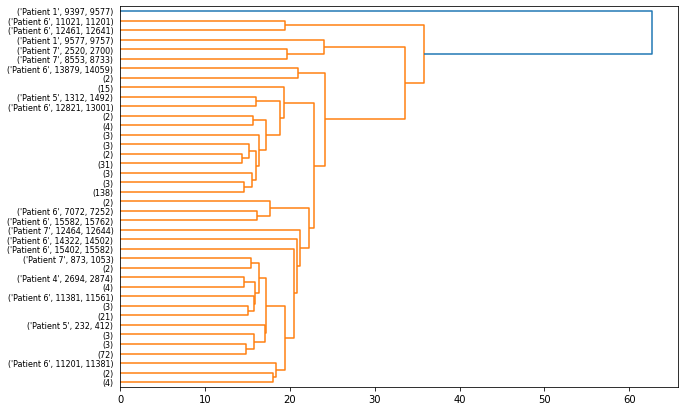

In [36]:
plt.figure(figsize=(10, 7))
# matplotlib.rc('axes',edgecolor='k')
dendrogram(
    hierarchical,
    orientation='right',
    truncate_mode='lastp',  # show only the last p merged clusters for readability
    p=40,  
    labels=metadata_pts,
    distance_sort='descending',
    show_leaf_counts=True,
    leaf_rotation=0.,)
plt.show()

### Plot an embedding of the data using the distance matrix

In [37]:
embedding = MDS(n_components=2, dissimilarity='precomputed', random_state=326)
X_transformed = embedding.fit_transform(euc_dist_matrix)

Text(0.5, 1.0, 'MDS embedding using euclidean distance matrix')

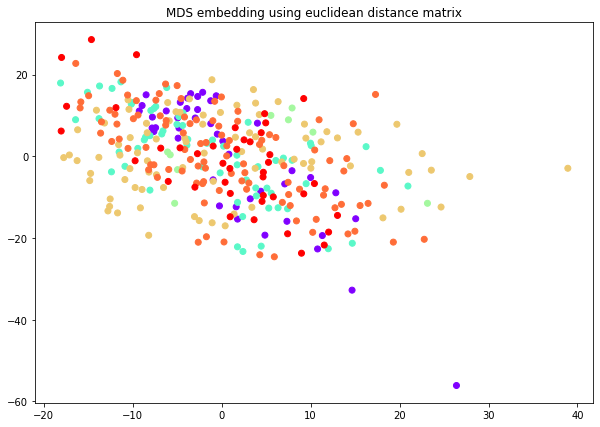

In [38]:
# colours here *should* correspond to patient?
plt.figure(figsize=(10, 7))
plt.scatter(X_transformed[:,0], X_transformed[:,1],
           c=source_file_list,
           cmap='rainbow',
           )
plt.title('MDS embedding using euclidean distance matrix')

## DTW with tslearn

Uses the Euclidean distance between pairwise elements in the time series, but between all timesteps, and will construct the shortest 'path' through the resulting matrix. In other words, this 'optimal alignment path' is the contiguous path through the matrix of squared element-wise differences between both sequences that minimizes the cumulative distance between them.

<!-- $$\left( \sqrt{(A_{00}-B_{00})^2 + \cdots + (A_{i0}-B_{i0})^2} + \sqrt{(A_{01}-B_{01})^2 + \cdots + (A_{i1}-B_{i1})^2} + \sqrt{(A_{02}-B_{02})^2 + \cdots + (A_{i2}-B_{i2})^2} \right) $$ -->

Dimentions needed:
`shape(n_ts, sz, d)` where
- `n_ts` is number of time series 
    - (in this case, `for df in dfs: n_ts += len(df)//720` = 47 as done above)
- `sz` is length of time series (number of time instants)
    - in this case, sz = 720
- `d` is dimensionality of time series
    - d = 3 here

In [39]:
# get the data into appropriate format
X_ts = np.empty((len(data), length, smoothed_dfs[0].shape[1]))
for i, seg in enumerate(data):
    X_ts[i] = seg
X_ts.shape

(341, 180, 2)

### Plot an embedding of the data using the distance matrix

In [40]:
# get the dtw distance matrix and create an embedding of it
dtw_dist_matrix = cdist_dtw(X_ts)
X_dtw_transformed = embedding.fit_transform(dtw_dist_matrix)

Text(0.5, 1.0, 'MDS embedding using DTW distance matrix')

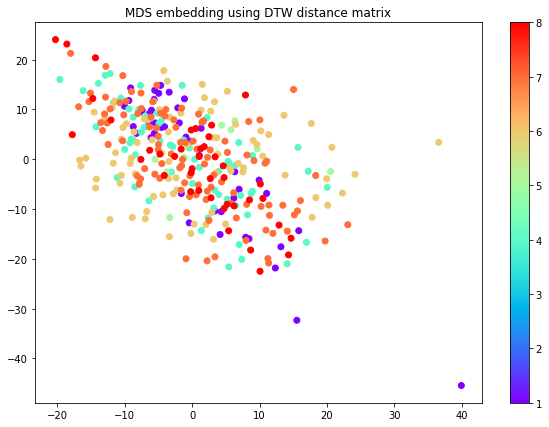

In [41]:
plt.figure(figsize=(10, 7))
plt.scatter(X_dtw_transformed[:,0], X_dtw_transformed[:,1],
           c=source_file_list,
           cmap='rainbow')
plt.colorbar()
plt.title('MDS embedding using DTW distance matrix')

### Greyscale

In [42]:
def plot_single_trajectory(labels=source_file_list, 
                           metric='euclidean', 
                           color_file=1, 
                           seed=0, # actually not used
                           ax=None
                          ): 
    """    
    metric: str, default='euclidean'
        The distance matrix to use for the embedding, can be euclidean or dtw
        
    labels: 1D array or list of len(embedding.shape[0])
        The labels corresponding to the files in the embedding
    
    color_file: int, default=1
        index of the file to appear in red; all others will be grey
        
    """

    sfl_greyscale = [1 if i==color_file else 0 for i in labels]
    sfl_greyscale = np.asarray(sfl_greyscale)
    
    # make a color map of fixed colors
    cmap = colors.ListedColormap(['grey', 'red'])

    # hackery to get the index of the last 1 value in the array (and first)
    start = sfl_greyscale.argmax()
    end = sfl_greyscale.shape[0] - sfl_greyscale[::-1].argmax()
    
    if metric=='euclidean':
        X_embed = X_transformed
        title = f'MDS embedding using Euclidean distance matrix'
    elif metric=='dtw':
        X_embed = X_dtw_transformed
        title = f'MDS embedding using DTW distance matrix'
    else:
        print('Distance metric not recognized.')
        return
        
    
    # plot the things
    plt.figure(figsize=(6, 4))
    plt.scatter(X_embed[:,0], X_embed[:,1],
               c=sfl_greyscale,
               cmap=cmap)

    if sfl_greyscale.max() == 1:
        plt.plot(X_embed[start:end,0], X_embed[start:end,1],  '.r-', 
                 label=f"Patient {color_file}")

        plt.annotate(f"Start", 
                     (X_embed[start,0], X_embed[start,1]),
                     xytext=(1,5),
                     textcoords="offset points",
                    )
        plt.annotate(f"End", 
                     (X_embed[end-1,0], X_embed[end-1,1]), #end-1 for correct indexing
                     xytext=(5,0),
                     textcoords="offset points",
                    )
    plt.xticks([])
    plt.yticks([])
    plt.legend()
#     plt.title(title)
    plt.tight_layout()
    plt.savefig(f'figures/mds-pt{color_file}', format='pdf')

In [43]:
def plot_two_trajectories(labels=source_file_list, metric='euclidean', color_file=[1,6]):
    """
    data: list of 2D arrays
        processed and split data
    
    metric: str, default='euclidean'
        The distance matrix to use for the embedding, can be euclidean or dtw
        
    labels: 1D array or list of len(embedding.shape[0])
        The labels corresponding to the files in the embedding
    
    color_file: int, default=1
        index of the file to appear in red; all others will be grey
        
    """
    
    # fixed colors and line types for plotting, must be same len as color_file
    plt_colors = ['.r-', '.b-']
    
    if metric=='euclidean':
        X_embed = X_transformed
        title = f'MDS embedding using Euclidean distance matrix'
    elif metric=='dtw':
        X_embed = X_dtw_transformed
        title = f'MDS embedding using DTW distance matrix'
    else:
        print('Distance metric not recognized.')
        return
        
    
    # plot the things
    plt.figure(figsize=(10, 7))
    plt.scatter(X_embed[:,0], X_embed[:,1],
               c='grey')

    for j in range(len(color_file)):
        sfl_greyscale = [1 if i==color_file[j] else 0 for i in labels]
        sfl_greyscale = np.asarray(sfl_greyscale)
        
        # hackery to get the index of the last 1 value in the array (and first)
        start = sfl_greyscale.argmax()
        end = sfl_greyscale.shape[0] - sfl_greyscale[::-1].argmax()
        
        if sfl_greyscale.max() == 1:
            plt.plot(X_embed[start:end,0], X_embed[start:end,1],  plt_colors[j], 
                     label=f"File {color_file[j]}")

            plt.annotate(f"Start", 
                         (X_embed[start,0], X_embed[start,1]),
                         xytext=(1,5),
                         textcoords="offset points",
                        )
            plt.annotate(f"End", 
                         (X_embed[end-1,0], X_embed[end-1,1]), #end-1 for correct indexing
                         xytext=(5,0),
                         textcoords="offset points",
                        )
    plt.xticks([])
    plt.yticks([])
    plt.legend()
#     plt.title(title)

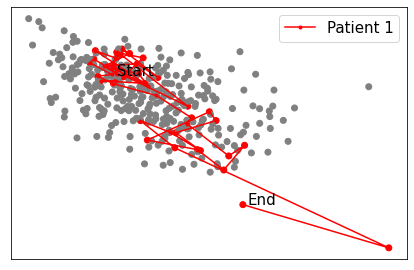

In [44]:
plt.rcParams.update({'font.size': 15, "axes.facecolor": (1.0, 1.0, 1.0, 0.0), 'text.color': 'k'}) # last entry is transparency
plot_single_trajectory(metric='dtw', color_file=1)

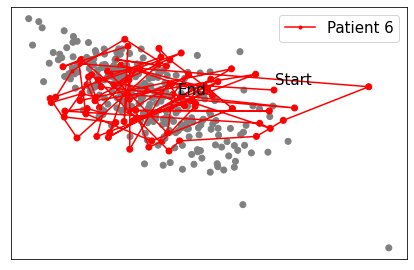

In [45]:
plot_single_trajectory(metric='dtw', color_file=6)

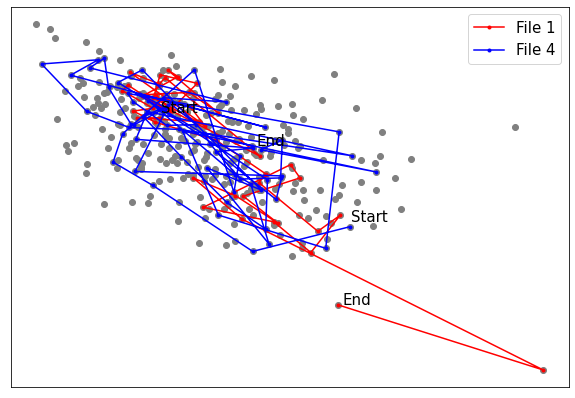

In [46]:
plot_two_trajectories(metric='dtw', color_file=[1,4])

# Plots for paper

In [47]:
file = 6
start_times = []

for md in metadata:
    if int(md[0][-1]) == file:
        start_times.append(md[1]) # get start time
        
df = dfs[file].reset_index()
smoothed_df = smoothed_dfs[file].reset_index()

In [48]:
len(df)

30316

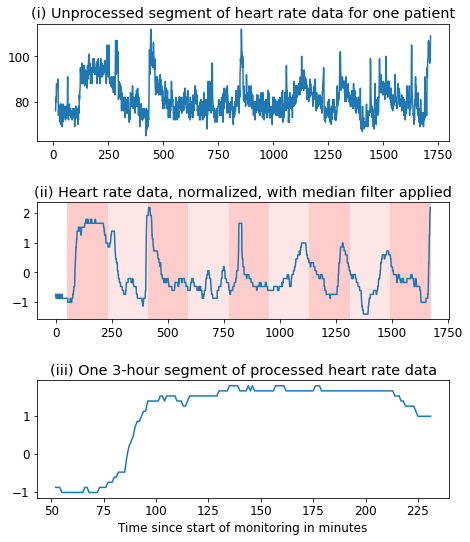

In [49]:
import matplotlib.ticker as plticker
plt.rcParams.update({'font.size': 12})

fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(7, 8))

df['Lifetouch Heart Rate'][:].plot(
    ax=axs[0])
axs[0].set_title('(i) Unprocessed segment of heart rate data for one patient')
# axs[0].text(0.05, 0.95, '(i)', 
#             horizontalalignment='center', 
#             verticalalignment='center', 
#             transform=axs[0].transAxes)


smoothed_df['Lifetouch Heart Rate'][:].plot(
    ax=axs[1])
for start in start_times[::2]:
    axs[1].axvspan(start, start+length, facecolor='#ffcccc')
for start in start_times[1::2]:
    axs[1].axvspan(start, start+length, facecolor='#ffe6e6')
axs[1].set_title('(ii) Heart rate data, normalized, with median filter applied')

smoothed_df[start_times[0]:start_times[0]+length]['Lifetouch Heart Rate'].plot(
    ax=axs[2], xlabel="Time since start of monitoring in minutes")
axs[2].set_title(f'(iii) One {length/60:.0f}-hour segment of processed heart rate data')



fig.tight_layout(pad=2.0)
plt.savefig('figures/processingsteps.pdf', format='pdf')
plt.show()

In [50]:
dtw_dist_matrix

array([[ 0.        ,  4.84916678,  8.26523044, ...,  8.06371545,
         8.66677001,  6.0057777 ],
       [ 4.84916678,  0.        ,  8.57845138, ...,  9.17645296,
        10.86830641,  9.77036714],
       [ 8.26523044,  8.57845138,  0.        , ...,  7.72715557,
         7.44061586,  6.89599833],
       ...,
       [ 8.06371545,  9.17645296,  7.72715557, ...,  0.        ,
         4.00900269,  5.4989803 ],
       [ 8.66677001, 10.86830641,  7.44061586, ...,  4.00900269,
         0.        ,  4.05074665],
       [ 6.0057777 ,  9.77036714,  6.89599833, ...,  5.4989803 ,
         4.05074665,  0.        ]])

In [51]:
squareform(dtw_dist_matrix)

array([ 4.84916678,  8.26523044, 10.15788564, ...,  4.00900269,
        5.4989803 ,  4.05074665])

In [52]:
# hierarchical clustering using DTW distance matrix
hierarchical_dtw = linkage(squareform(dtw_dist_matrix), method="average")
hierarchical_dtw

array([[ 91.        ,  97.        ,   2.53939933,   2.        ],
       [ 15.        , 264.        ,   2.75553222,   2.        ],
       [289.        , 291.        ,   2.86092022,   2.        ],
       ...,
       [ 42.        , 165.        ,  32.58218753,   2.        ],
       [ 43.        , 677.        ,  36.96822888, 339.        ],
       [678.        , 679.        ,  49.77889854, 341.        ]])

Note to self: in case you were tempted to use the Ward variance minimization algorithm for clustering method, don't. It requires the original coordinates, and produces nonsense with a precomputed distance matrix.

In [53]:
hierarchical_dtw.max()
np.where(hierarchical_dtw == np.amax(hierarchical_dtw))

(array([339], dtype=int64), array([1], dtype=int64))

In [54]:
# 2% of epochs is...
hierarchical_dtw.shape[0]*0.02

6.8

In [55]:
len(metadata)*0.01

3.41

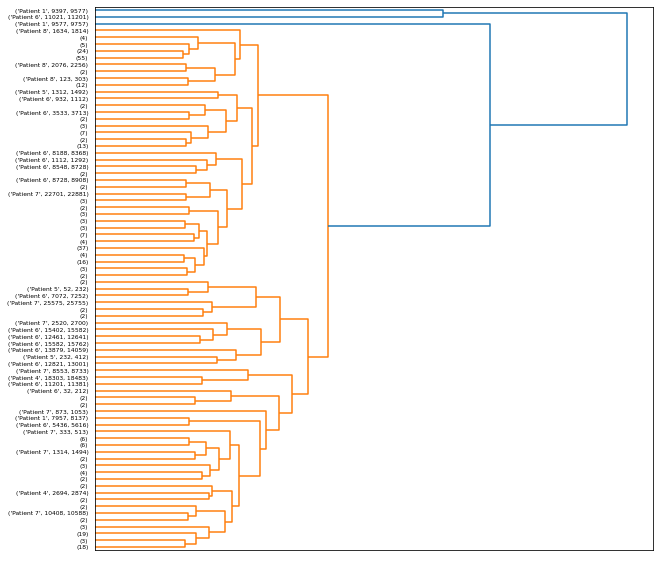

In [56]:
plt.figure(figsize=(10, 10))
dendrogram(
    hierarchical_dtw,
    orientation='right',
    truncate_mode='lastp',  # show only the last p merged clusters
    p=80,  # 7 is 2%, some fiddling got 25 clusters shows us 7
    labels=metadata_pts,
    distance_sort='descending',
    show_leaf_counts=True,
    leaf_rotation=0.,
    color_threshold=0.45*max(hierarchical_dtw[:,2]),
    )
# plt.title("Trucated dendrogram of epoch clusters\n using DTW distance measure")
plt.xticks([])
plt.rcParams.update({'font.size': 15, "axes.facecolor": (1.0, 1.0, 1.0, 0.0), 'text.color': 'k', 
                     'axes.labelcolor' : 'k'})
# plt.savefig('figures/al-dendrogram', format='pdf', bbox_inches='tight')
plt.show()

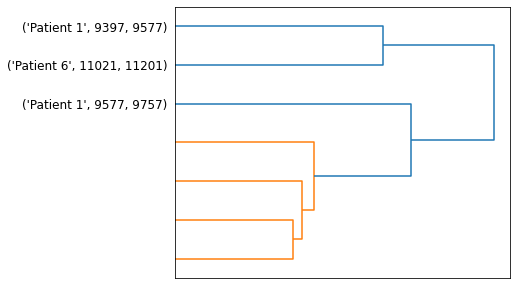

In [57]:
plt.figure(figsize=(6, 5))
dendrogram(
    hierarchical_dtw,
    orientation='right',
    truncate_mode='lastp',  # show only the last p merged clusters
    p=7,  # 7 is 2%, some fiddling got 25 clusters shows us 7
    labels=metadata_pts,
    distance_sort='descending',
    show_leaf_counts=False,
    leaf_rotation=0.,
    color_threshold=0.45*max(hierarchical_dtw[:,2]),
    )
# plt.title("Trucated dendrogram of epoch clusters\n using DTW distance measure")
plt.xticks([])
plt.rcParams.update({'font.size': 15, "axes.facecolor": (1.0, 1.0, 1.0, 0.0), 'text.color': 'k', 
                     'axes.labelcolor' : 'k'})
plt.savefig('figures/al-dendrogram', format='pdf', bbox_inches='tight')
plt.show()

[('File 7', 0, 180),
 ('File 9', 360, 540),
 ('File 7', 15360, 15540),
 ('File 7', 12558, 12738),
 ('File 6', 180, 360),
 ('File 8', 360, 540),
 ('File 1', 9412, 9592)]

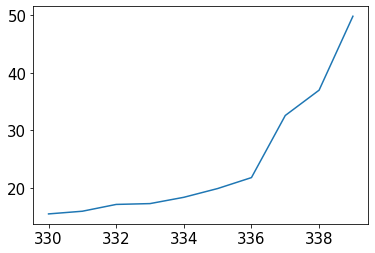

In [58]:
xs = np.arange(hierarchical_dtw[:,2].shape[0])
fig, ax = plt.subplots()
ax.plot(xs[-10:], hierarchical_dtw[:,2][-10:])


plt.show()

In [59]:
truncate_p = 50
hierarchical_dtw[340-truncate_p:340,0]

array([ 98., 592., 588., 479., 618., 121., 628., 525., 586., 523.,  61.,
       584., 606., 590., 276., 188., 607., 154., 107., 615., 113., 635.,
       625., 634., 643., 210., 200., 115., 644., 627., 180., 651., 657.,
       307., 648., 240., 662., 638., 664., 617., 656., 203., 658., 668.,
       666., 674., 669.,  42.,  43., 678.])

In [60]:
idxs = np.where(hierarchical_dtw[340-truncate_p:340,0] <= 339)[0] + 340-truncate_p
idxs

array([290, 295, 300, 304, 305, 307, 308, 310, 315, 316, 317, 320, 323,
       325, 331, 337, 338], dtype=int64)

In [61]:
top_outliers = [ metadata[i] for i in hierarchical_dtw[idxs][:,0].astype(int)]
top_outliers[::-1]

[('File 1', 9577, 9757),
 ('File 1', 9397, 9577),
 ('File 8', 873, 1053),
 ('File 8', 8553, 8733),
 ('File 9', 1634, 1814),
 ('File 7', 13879, 14059),
 ('File 7', 32, 212),
 ('File 8', 333, 513),
 ('File 8', 2520, 2700),
 ('File 6', 1312, 1492),
 ('File 6', 232, 412),
 ('File 7', 8188, 8368),
 ('File 7', 15402, 15582),
 ('File 8', 25575, 25755),
 ('File 5', 2694, 2874),
 ('File 7', 1112, 1292),
 ('File 5', 18303, 18483)]

In [62]:
top_outliers_cmap_list = np.zeros(len(metadata))
top_outliers_cmap_list[hierarchical_dtw[idxs][:,0].astype(int)] = 1
top_outliers_cmap_list

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [63]:
embedding = MDS(n_components=2, dissimilarity='precomputed', random_state=0)
X_dtw_transformed = embedding.fit_transform(dtw_dist_matrix)

Text(0.5, 1.0, 'MDS embedding using DTW distance matrix')

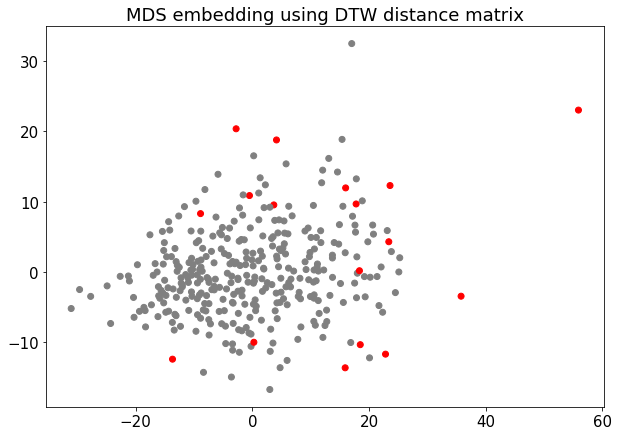

In [64]:
plt.figure(figsize=(10, 7))
# make a color map of fixed colors
cmap = colors.ListedColormap(['grey', 'red'])
plt.scatter(X_dtw_transformed[:,0], X_dtw_transformed[:,1],
           c=top_outliers_cmap_list,
           cmap=cmap)
plt.title('MDS embedding using DTW distance matrix')

In [65]:
file = 1
df = dfs_raw[file].reset_index()
smoothed_df = smoothed_dfs[file].reset_index()

start_times = []
for md in metadata:
    if int(md[0][-1]) == file:
        start_times.append(md[1]) # get start time

In [66]:
df['Hours from start'] = (df.index.values/60).astype(int)

In [67]:
df['Hours from start']

0          0
1          0
2          0
3          0
4          0
        ... 
40355    672
40356    672
40357    672
40358    672
40359    672
Name: Hours from start, Length: 40360, dtype: int32

In [68]:
df.set_index('Hours from start')

,Timestamp_GMTStandardTime_,Lifetouch Heart Rate,Lifetouch Respiration Rate,Lifetouch Patient Orientation,Lifetemp Temperature,Oximeter SpO2,Oximeter Pulse,Early Warning Score,Early Warning Max
Hours from start,,,,,,,,,
0,5/23/2021 0:14,NaN,NaN,NaN,NaN,99.0,87.0,NaN,NaN
0,5/23/2021 0:15,NaN,NaN,NaN,NaN,100.0,88.0,NaN,NaN
0,5/23/2021 0:16,NaN,NaN,NaN,NaN,99.0,87.0,NaN,NaN
0,5/23/2021 0:17,NaN,NaN,NaN,NaN,97.0,87.0,NaN,NaN
0,5/23/2021 0:18,NaN,NaN,NaN,NaN,100.0,86.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...
672,6/19/2021 23:49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
672,6/19/2021 23:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
672,6/19/2021 23:51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [97]:
def plot_twinx(df, title, label, start_times=None, fixed_yax=False):
    fig, ax1 = plt.subplots(figsize=(10.5,3.1))
    if fixed_yax:
        fig.set_size_inches(6,3.5)
    ax1.set_title(title)

    colorlist = ['tab:blue', 'tab:red']
    df['Lifetouch Respiration Rate'][:].plot(ax=ax1, color=colorlist[0])
#     ax1.plot( df['Hours from start'], df['Lifetouch Respiration Rate'][:])
    ax1.set_xlabel("Time since start of monitoring in minutes")
    ax1.set_ylabel('Respiration Rate', color=colorlist[0])
    ax1.tick_params(axis='y', labelcolor=colorlist[0])

    ax2 = ax1.twinx()
    df['Lifetouch Heart Rate'][:].plot(ax=ax2, color=colorlist[1])
#     ax2.plot(df['Hours from start'], df['Lifetouch Heart Rate'][:])
    ax2.set_ylabel('Heart Rate', color=colorlist[1])
    ax2.tick_params(axis='y', labelcolor=colorlist[1])

    if start_times is not None:
        midpoint = (len(start_times)-1)//2

        #for start in start_times[::midpoint]:
        # plot start, middle, and end
        ax1.axvspan(start_times[0], start_times[0]+length, facecolor='#ccddff')
        ax1.axvspan(start_times[midpoint], start_times[midpoint]+length, facecolor='#ccddff')
        ax1.axvspan(start_times[-1], start_times[-1]+length, facecolor='#ccddff')
    if fixed_yax:
        ax1.set_ylim([-1.5, 6])
        ax2.set_ylim([-1.5, 6])

    plt.savefig(f'figures/{label}.png', format='png')
    plt.show()

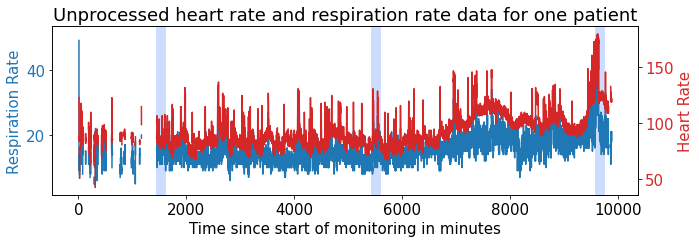

In [98]:
plot_twinx(
    df, 
    title='Unprocessed heart rate and respiration rate data for one patient', 
    label='pt1-full', 
    start_times=start_times
)

In [71]:
import math
l = [0, 1, 2, 3, 4, 5]
midpoint = (len(l)-1)//2
for i in l[::midpoint]:
    print(l[i])

0
2
4


In [72]:
print(smoothed_df['Lifetouch Respiration Rate'].min())
print(smoothed_df['Lifetouch Respiration Rate'].max())

-1.4119488780105054
5.5292478614463825


In [73]:
print(smoothed_df['Lifetouch Heart Rate'].min())
print(smoothed_df['Lifetouch Heart Rate'].max())

-1.3982747993128846
5.216379296163833


In [74]:
hr_ax = np.linspace(smoothed_df['Lifetouch Heart Rate'].min(), smoothed_df['Lifetouch Heart Rate'].max())
hr_ax

array([-1.3982748 , -1.26328186, -1.12828892, -0.99329598, -0.85830304,
       -0.7233101 , -0.58831715, -0.45332421, -0.31833127, -0.18333833,
       -0.04834539,  0.08664755,  0.22164049,  0.35663343,  0.49162637,
        0.62661931,  0.76161225,  0.89660519,  1.03159813,  1.16659107,
        1.30158402,  1.43657696,  1.5715699 ,  1.70656284,  1.84155578,
        1.97654872,  2.11154166,  2.2465346 ,  2.38152754,  2.51652048,
        2.65151342,  2.78650636,  2.9214993 ,  3.05649224,  3.19148519,
        3.32647813,  3.46147107,  3.59646401,  3.73145695,  3.86644989,
        4.00144283,  4.13643577,  4.27142871,  4.40642165,  4.54141459,
        4.67640753,  4.81140047,  4.94639341,  5.08138636,  5.2163793 ])

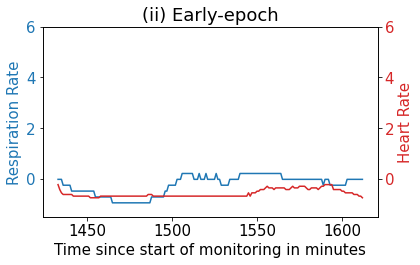

In [75]:
start = start_times[0]

plot_twinx(
    smoothed_df[start:start+length], 
    title='(ii) Early-epoch', 
    label='pt1-start',
    fixed_yax=True
)

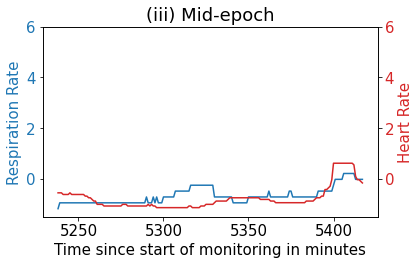

In [94]:
start = start_times[int(len(start_times)/2 - 1)]

plot_twinx(
    smoothed_df[start:start+length], 
    title='(iii) Mid-epoch', 
    label='pt1-mid',
    fixed_yax=True
)

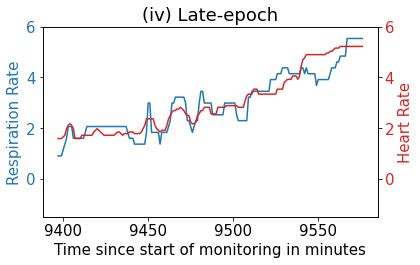

In [95]:
start = start_times[-1]

plot_twinx(
    smoothed_df[start-length:start], 
    title='(iv) Late-epoch', 
    label='pt1-late',
    fixed_yax=True
)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


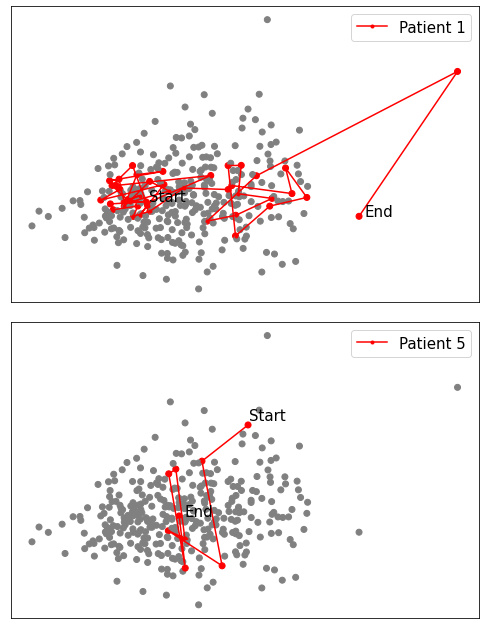

In [78]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(7, 9))

for i, color_file in enumerate([1,5]):

    sfl_greyscale = [1 if i==color_file else 0 for i in source_file_list]
    sfl_greyscale = np.asarray(sfl_greyscale)

    # make a color map of fixed colors
    cmap = colors.ListedColormap(['grey', 'red'])

    # hackery to get the index of the last 1 value in the array (and first)
    start = sfl_greyscale.argmax()
    end = sfl_greyscale.shape[0] - sfl_greyscale[::-1].argmax()
    
    axs[i].scatter(X_dtw_transformed[:,0], X_dtw_transformed[:,1],
               c=sfl_greyscale,
               cmap=cmap)

    if sfl_greyscale.max() == 1:
        axs[i].plot(X_dtw_transformed[start:end,0], X_dtw_transformed[start:end,1],  '.r-', 
                 label=f"Patient {color_file}")

        axs[i].annotate(f"Start", 
                     (X_dtw_transformed[start,0], X_dtw_transformed[start,1]),
                     xytext=(1,5),
                     textcoords="offset points",
                    )
        axs[i].annotate(f"End", 
                     (X_dtw_transformed[end-1,0], X_dtw_transformed[end-1,1]), #end-1 for correct indexing
                     xytext=(5,0),
                     textcoords="offset points",
                    )
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i].legend()
# axs[0].set_title('MDS embeddings using DTW distance matrix')
fig.tight_layout()
fig.savefig(f'figures/mds-two-patients.eps', format='eps')

100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:06<00:00,  7.75it/s]


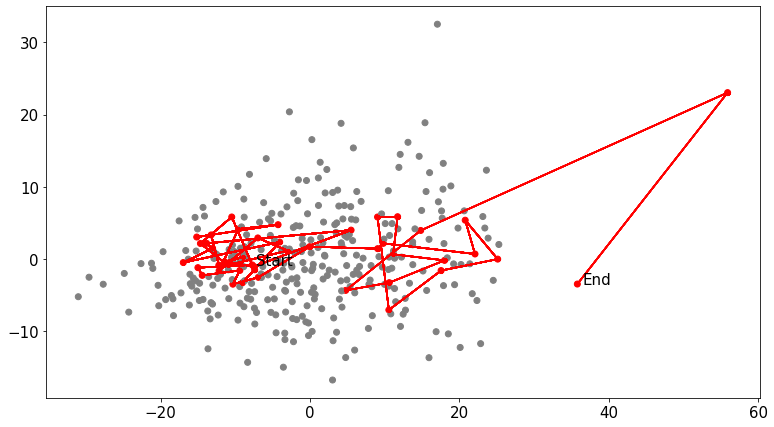

In [79]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from pathlib import Path
from tqdm import tqdm

plt.rcParams.update({'font.size': 15, "axes.facecolor": (1.0, 1.0, 1.0, 1.0)})

if __name__ == "__main__":
    output_dir = Path('j')
    output_dir.mkdir(exist_ok=True)

#     xs = np.linspace(0, 4 * np.pi, 200)

fig, ax = plt.subplots(1, figsize=(12.8, 7.2), facecolor='white')
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('black')
        
ax.set_facecolor('w')
    

sfl_greyscale = [1 if i==1 else 0 for i in source_file_list] # color_file = 1
sfl_greyscale = np.asarray(sfl_greyscale)

# make a color map of fixed colors
cmap = colors.ListedColormap(['grey', 'red'])

# hackery to get the index of the last 1 value in the array (and first)
start = sfl_greyscale.argmax()
end = sfl_greyscale.shape[0] - sfl_greyscale[::-1].argmax()

ax.scatter(X_dtw_transformed[:,0], X_dtw_transformed[:,1],
           c=sfl_greyscale,
           cmap=cmap)

if sfl_greyscale.max() == 1:
    ax.annotate(f"Start", 
                 (X_dtw_transformed[start,0], X_dtw_transformed[start,1]),
                 xytext=(1,5),
                 textcoords="offset points",
                 color='black'
                )
    ax.annotate(f"End", 
                 (X_dtw_transformed[end-1,0], X_dtw_transformed[end-1,1]), #end-1 for correct indexing
                 xytext=(5,0),
                 textcoords="offset points",
                 color='black'
                )
    for j in tqdm(range(end+10)):
        if j > end: # to linger on the last frame
            xs = X_dtw_transformed[start:end,0]
            ys = X_dtw_transformed[start:end,1]
        else:
            xs = X_dtw_transformed[start:start+j,0]
            ys = X_dtw_transformed[start:start+j,1] #, X_dtw_transformed[start:start+j,1],  '.r-', 
                 #label=f"Patient {color_file}")

#     num_frames = 300
#     for frame in tqdm(range(num_frames)): #for i in range max idx, start:i
#         ys = np.cos(xs + 0.01 * frame)

        ax.plot(xs, ys, '.r-')
        plt.savefig(output_dir / f'{j:03d}.png', dpi=100, facecolor='w')# transparent=False)
#                 ax.clear()

In [80]:
for i, color_file in enumerate([1,8]):
    print(i)
    print(color_file)

0
1
1
8


In [81]:
thresh_pct = 0.7
thresh=thresh_pct*max(hierarchical_dtw[:,2])
y_pred = hierarchy.fcluster(hierarchical_dtw, thresh, criterion='distance')

In [82]:
np.unique(y_pred)

array([1, 2, 3], dtype=int32)

In [83]:
# last 3 points to be clustered = greatest outliers; first 2 cols. of this array gives original indices
# only one of original points if the index is < n_epochs, in this case n < 341
print(f"n_epochs: {X_dtw_transformed.shape[0]}")
print(f"{thresh_pct*100:.0f}th percentile: {X_dtw_transformed.shape[0]*(1-thresh_pct):.0f}")
hierarchical[-52:]

n_epochs: 341
70th percentile: 102


array([[ 73.        , 590.        ,  13.17223999,   4.        ],
       [276.        , 303.        ,  13.17414201,   2.        ],
       [190.        , 595.        ,  13.28276119,   4.        ],
       [598.        , 626.        ,  13.49564926,  91.        ],
       [614.        , 622.        ,  13.56068455,  21.        ],
       [558.        , 565.        ,  13.56433769,   4.        ],
       [621.        , 632.        ,  13.67484471, 138.        ],
       [609.        , 624.        ,  13.68754186,  30.        ],
       [625.        , 628.        ,  13.75182619,  68.        ],
       [631.        , 637.        ,  13.98560342,  72.        ],
       [124.        , 636.        ,  14.03725169,  31.        ],
       [574.        , 605.        ,  14.14136311,  15.        ],
       [141.        , 566.        ,  14.16256136,   3.        ],
       [572.        , 639.        ,  14.31946037,  33.        ],
       [ 61.        , 620.        ,  14.51624956,   5.        ],
       [607.        , 635

([], [])

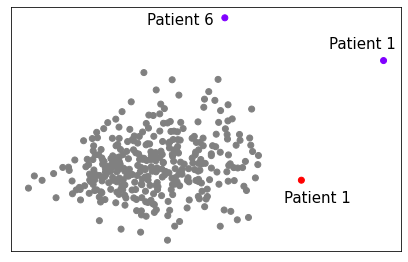

In [84]:
plt.figure(figsize=(7, 4.5))

cmap = plt.cm.rainbow
# extract all colors from the map 
# from https://stackoverflow.com/questions/14777066/matplotlib-discrete-colorbar
cmaplist = [cmap(i) for i in range(cmap.N)]
# force the first color entry to be grey
# or the middle one, I guess, since I cba remapping y_pred
cmaplist[127] = (.5, .5, .5, 1.0)
# create the new map
cmap = colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)
# define the bins and normalize
n_clust = int(np.max(y_pred))
bounds = np.linspace(1, n_clust, n_clust+1)
norm = colors.BoundaryNorm(bounds, cmap.N)

plt.scatter(X_dtw_transformed[:,0], X_dtw_transformed[:,1],
           c=y_pred,
           cmap=cmap, norm=norm)

# last 3 points to be clustered = greatest outliers in their cluster; first col. of this array gives original indices

plt.annotate(f"Patient 1", 
        (X_dtw_transformed[43,0], X_dtw_transformed[43,1]),
        xytext=(-17,-22),
        textcoords="offset points",
        bbox=dict(boxstyle="square", fc="w", ec="w")
        )

plt.annotate(f"Patient 1", 
        (X_dtw_transformed[42,0], X_dtw_transformed[42,1]),
        xytext=(-55,12),
        textcoords="offset points",
        bbox=dict(boxstyle="square", fc="w", ec="w")
        )

plt.annotate(f"Patient 6", 
        (X_dtw_transformed[165,0], X_dtw_transformed[165,1]),
        xytext=(-78,-7),
        textcoords="offset points",
        bbox=dict(boxstyle="square", fc="w", ec="w")
        )

plt.xticks([])
plt.yticks([])
# plt.legend()
# plt.colorbar()
# plt.title('MDS embedding using DTW distance matrix')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


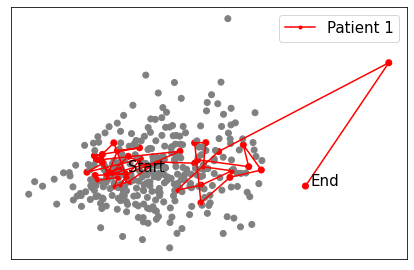

In [85]:


sfl_greyscale = [1 if i==1 else 0 for i in source_file_list]
sfl_greyscale = np.asarray(sfl_greyscale)

# make a color map of fixed colors
cmap = colors.ListedColormap(['grey', 'red'])

# hackery to get the index of the last 1 value in the array (and first)
start = sfl_greyscale.argmax()
end = sfl_greyscale.shape[0] - sfl_greyscale[::-1].argmax()

plt.scatter(X_dtw_transformed[:,0], X_dtw_transformed[:,1],
           c=sfl_greyscale,
           cmap=cmap)

if sfl_greyscale.max() == 1:
    plt.plot(X_dtw_transformed[start:end,0], X_dtw_transformed[start:end,1],  '.r-', 
             label=f"Patient 1")

    plt.annotate(f"Start", 
                 (X_dtw_transformed[start,0], X_dtw_transformed[start,1]),
                 xytext=(1,5),
                 textcoords="offset points",
                )
    plt.annotate(f"End", 
                 (X_dtw_transformed[end-1,0], X_dtw_transformed[end-1,1]), #end-1 for correct indexing
                 xytext=(5,0),
                 textcoords="offset points",
                )
plt.xticks([])
plt.yticks([])
plt.legend()
plt.tight_layout()
plt.savefig(f'figures/mds-pat1.eps', format='eps')


In [86]:
print(metadata[42])
print(metadata[43])
print(metadata[165])

('File 1', 9397, 9577)
('File 1', 9577, 9757)
('File 7', 11021, 11201)


Text(0.5, 1.0, 'MDS embedding using DTW distance matrix')

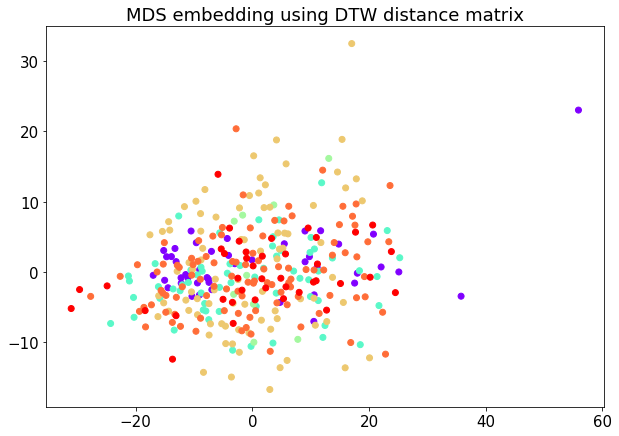

In [87]:
plt.figure(figsize=(10, 7))
plt.scatter(X_dtw_transformed[:,0], X_dtw_transformed[:,1],
           c=source_file_list,
           cmap='rainbow')
# plt.colorbar()
plt.title('MDS embedding using DTW distance matrix')

In [88]:
import scipy
from numpy.random import default_rng
rng = default_rng(8888)

In [89]:
def generate_data(n_patients=10, 
                  pct_abnormal=0.2, 
                  perturb_method=['gaussian', 'gradual rise', 'log', 'opposite'], 
                  perturb_mean=[1, 1], 
                  verbose=False):
    """
    pct_abnormal: percentage of patients for which to add a perturbation, float between 0 and 1
    perturb_method: ['constant', 'gaussian', 'gradual rise', 'steep rise', 'gradual drop', 'steep drop']
        constant: adds a flat value to existing series, basically increasing the means by amount
            set in perturb_constant
        gaussian: adds gaussian noise with a positive mean, set in perturb_mean
    """
    
    dfs_raw = []
    patient_list = list(range(1, n_patients+1)) #start at patient no. 1

    time_range = pd.date_range(start='1/1/2021', end='1/9/2021', freq='min') #starts and stops at midnight - this is 8 days
    
    for idx, df in enumerate(range(n_patients)):
        df = pd.DataFrame(time_range, columns=['Timestamp'])
        labels = np.zeros(time_range.shape[0])

        # generate mean, covariance matrices 
        # going to normalize them later anyway, so precise values don't matter
        mean = np.array([0,0])
        cov_r = rng.uniform(low=0.15, high=0.6, size=1)[0]
        cov = np.array([[1., cov_r],[cov_r, 1.]])
        vitals = rng.multivariate_normal(mean, cov, time_range.shape[0])
        
        # add some sinusoidal variation (an abomination of a function, see graph below)
        freq = 1/(24*60) # 1 day, Hz*60 (minutes)
        ph = rng.integers(0, 60*12) # also in minutes, up to 12h lag
        amp = 0.25 # in std. devs 
        rhythm = np.fromfunction(lambda i, j: \
            -0.3*j*(amp*np.sin(2*np.pi*freq*i + ph)+0.15*np.sin(2*np.pi/240*i+10)) + \
            amp*(np.sin(2*np.pi*freq*i + ph)+0.05*np.sin(2*np.pi/240*i)), \
            vitals.shape, dtype=float)     
        vitals += rhythm
        
        # add some nonstationary elements? let's try some top hat functions
        # always add at the end of the time series to make my life easier, say the last 10% 
        # (approx 21.5 hours if using 9 days e.g. start='1/1/2021', end='1/8/2021')     
        # series of top hats with gaussian noise
        if 'gaussian' in perturb_method:
            if idx+1 > n_patients*pct_abnormal and idx+1 <= n_patients*pct_abnormal*2:
                cov_r = rng.uniform(low=0.15, high=0.4, size=(1,2)) # increase variance a bit
                cov = cov_r.T*cov_r
                perturb_var = rng.multivariate_normal((0,0), cov, time_range.shape[0]) # add some variance to both
                t = np.arange(time_range.shape[0])
                perturb_mean = np.where(t%600 <=120, 2, 0) # bunch of little top hats
                
                perturb_idx = int(time_range.shape[0]*0.9) # change vals AFTER this
                perturb_mean[:perturb_idx] = 0
                perturb_var[:perturb_idx] = 0
                vitals[:,0] += perturb_mean # NOTE: changed here to only change ONE vital sign
                vitals += perturb_var
                labels[perturb_idx+1:] = 1
                
                if verbose:
                    print(f"perturbed (gaussian). Label 1")
                
        # increase over the period of a day
        if 'gradual rise' in perturb_method:
            if idx+1 > n_patients*pct_abnormal*2 and idx+1 <= n_patients*pct_abnormal*3:
                # linear increase in 2D, from 24 hours before end of recording
                perturb_idx = int(24*60) # 24 hours of indices - take LAST 
                perturb = np.zeros_like(vitals)
                # 2 standard deviations - big increase!
                perturb[-perturb_idx:] = np.fromfunction(lambda i, j: i, (perturb_idx, 2), dtype=float)*(1.5/perturb_idx) 
                vitals += perturb
                # how early should we be able to detect this? There should be a trend, so instantly
                labels[-perturb_idx+1:] = 2
                
                if verbose:
                    print(f"perturbed (gradual rise). Label 2")
        
        # increase quickly and stay high
        if 'log' in perturb_method:
            if idx+1 > n_patients*pct_abnormal*3 and idx+1 <= n_patients*pct_abnormal*4:
                perturb = np.zeros_like(vitals)
                perturb_idx = int(time_range.shape[0]*0.1) # take from end to this idx, so -ve
                perturb[-perturb_idx:] = np.fromfunction(lambda i, j: np.log(i+1), (perturb_idx, 2), dtype=float)*(1/6)
                vitals += perturb
                labels[-perturb_idx+1:] = 3
                
                if verbose:
                    print(f"perturbed (logarithmic increase). Label 3")
            
        # vitals go in opposite directions
        if 'opposite' in perturb_method:
            if idx+1 > n_patients*pct_abnormal*4 and idx+1 <= n_patients*pct_abnormal*5:
                perturb = np.zeros_like(vitals)
                perturb_idx = int(time_range.shape[0]*0.1)
                perturb[-perturb_idx:] =  np.fromfunction(lambda i, j: j*2*np.log(i+1)-np.log(i+1), \
                                                          (perturb_idx, 2), dtype=float)*(1/6)
                vitals += perturb
                labels[-perturb_idx+1:] = 4
                
                if verbose:
                    print(f"perturbed (opposite directions). Label 4")
        
        if verbose:
            print(f"mean {np.mean(vitals)}")
            print(f"var {np.var(vitals)}\n")

        df['Lifetouch Heart Rate'] = vitals[:,0]
        df['Lifetouch Respiration Rate'] = vitals[:,1]
        df['Labels'] = labels
        dfs_raw.append(df)
        
    return dfs_raw, patient_list

In [90]:
def preprocessing(dfs_raw, length=180, window=25):
    # length parameter: 3 hours or 180 minutes
    # normalize then apply rolling window
    use_center=False
    smoothed_dfs = []
    labels = []

    # places in rightmost position in window, alternately can set center=True
    for df in dfs_raw:
        data = df[["Lifetouch Heart Rate", "Lifetouch Respiration Rate"]]
        ndf = (data - data.mean(skipna=True))/data.std(skipna=True)
        smoothed_dfs.append(ndf.rolling(window=window, center=use_center).median())
        labels.append(df["Labels"])
    
    return smoothed_dfs, labels


# length parameter is length of interval in minutes
def split_into_intervals(smoothed_dfs, labels, patient_list, length=180):
    data = []
    metadata = []
    source_file_list = []
    targets = []
    
    for idx, df in enumerate(smoothed_dfs):
        # initialize list into which we'll put the split arrays
        segments = [] 
        # and maybe a good idea to return the file index, start and stop indices
        metadata_pts = []
        source_list = []
        seg_labels = []

        # Find rows with any NaN values, create as mask
        # add leading and trailing buffer so we can compare to the next row sequentially
        mask = np.concatenate(( [True], df.isna().any(axis=1).to_numpy(), [True] ))

        # get start and stop limits, reshape them into array of (start, stop) pairs
        ss = np.flatnonzero(mask[1:] != mask[:-1]).reshape(-1,2)
        # mask to get contiguous data only greater in length than length parameter
        ss = ss[(ss[:,1] - ss[:,0]) > length]
        # find how many len(length) segments are in each contiguous block of data
        nb_splits = (ss[:,1] - ss[:,0])//length

        # finally, we can get our start, stop, nb_splits tuples and use np.split to
        # return a list of equal size arrays of our desired length
        starts = ss[:,0]
        ends = starts + nb_splits*length
        for start, end, nb_splits in zip(starts,ends,nb_splits):
            # Difference between append and extend here is how they're added to the 
            # list. Extend "flattens" the resulting list so we don't end up with extra
            # dimentions, but also we can't easily tell which original file the data 
            # belonged to, which is why I've included metadata. 
            segments.extend( np.split(df.to_numpy()[start:end],nb_splits) )
            seg_label = np.split(labels[idx].to_numpy()[start:end],nb_splits)
            for split in range(nb_splits):
                metadata_pts.append( ("Patient " + str(patient_list[idx]), start+split*length, start+(split+1)*length) )
                source_list.append(patient_list[idx])
                # find the modal label for this segment
                seg_labels.extend(scipy.stats.mode(seg_label[split])[0])
        
        if metadata_pts != []: # if no contiguous samples long enough, both lists are empty
            data.extend(segments)
            metadata.extend(metadata_pts)
            source_file_list.extend(source_list)
            targets.extend(seg_labels)
    
    return data, metadata, source_file_list, targets


def dtw_calc(data):    
    # take all the processed data, flatten each array, and add to a numpy array 
    # (n_epochs, epoch_length, n_variables)
    X_ts = np.empty((len(data), len(data[0]), smoothed_dfs[0].shape[1]))
    for i, seg in enumerate(data):
        X_ts[i] = seg
    # get the dtw distance matrix
    dtw_dist_matrix = cdist_dtw(X_ts)

    # Silhouette score
#     score = metrics.silhouette_score(dtw_dist_matrix, targets, metric="precomputed")
    
    return dtw_dist_matrix


def cluster_data(dtw_dist_matrix, targets):
    #hierarchical clustering using DTW distance matrix
    hierarchical_dtw = hierarchy.linkage(squareform(dtw_dist_matrix), method="average")

    # Silhouette score
    score = metrics.silhouette_score(dtw_dist_matrix, targets, metric="precomputed")

    return hierarchical_dtw, score

In [91]:
dfs_raw, patient_list = generate_data(n_patients=20, 
                  pct_abnormal=0.1, 
                  perturb_method=['gaussian', 'gradual rise', 'log', 'opposite'], 
                  perturb_mean=[1.3, 1],
                  verbose=True)

smoothed_dfs, labels = preprocessing(dfs_raw)

data, metadata, source_file_list, targets = \
    split_into_intervals(smoothed_dfs, labels, length=180, patient_list=patient_list)

mean 0.006587367682026591
var 1.0384080024827171

mean 0.012619650979548327
var 1.0242033579931051

perturbed (gaussian). Label 1
mean 0.02701064291527952
var 1.0768638144510185

perturbed (gaussian). Label 1
mean 0.028869435602841314
var 1.0725391280579806

perturbed (gradual rise). Label 2
mean 0.09367093693986991
var 1.1090391067410892

perturbed (gradual rise). Label 2
mean 0.10701780277346488
var 1.105182057159649

perturbed (logarithmic increase). Label 3
mean 0.09622840514013403
var 1.1330544309409651

perturbed (logarithmic increase). Label 3
mean 0.10548030178752757
var 1.1317711222019797

perturbed (opposite directions). Label 4
mean 0.0002788715147916179
var 1.1190367893099757

perturbed (opposite directions). Label 4
mean 0.007747245778259306
var 1.1538396117815968

mean 0.009877509101456343
var 1.0152283352768943

mean -0.0022577622096471373
var 1.0260373114140022

mean -0.005325050889790382
var 1.028956523871008

mean -0.005674004538279446
var 1.0191451739329591

mean 0.0

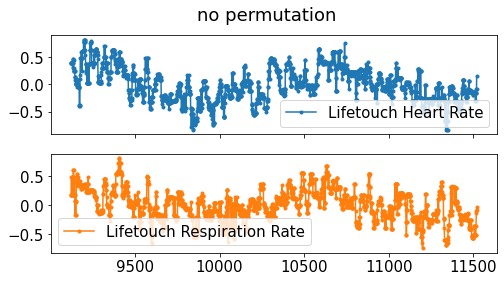

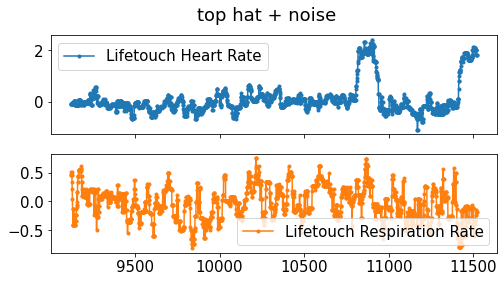

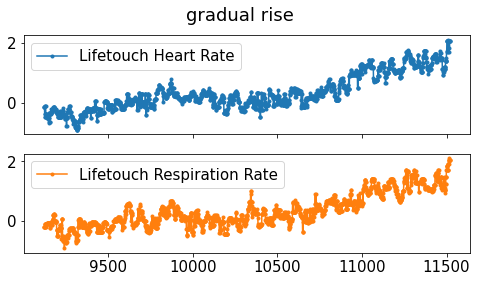

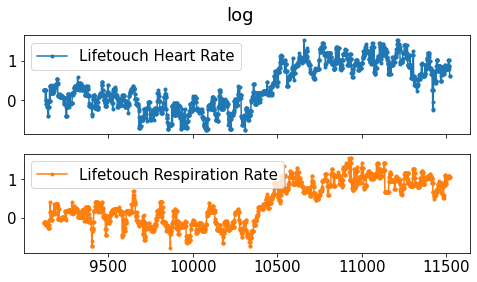

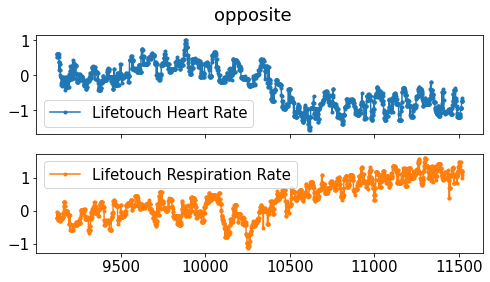

In [92]:
types = ['no permutation', 'top hat + noise', 'gradual rise', 'log', 'opposite']

n = 2 # n_patients*pct_abnormal

for i in range(5):
#     label = int(scipy.stats.mode(labels[i*n][-1100:], keepdims=True)[0][0])
    label = int(scipy.stats.mode(labels[i*n][-1100:])[0][0])
#     print(label)
    smoothed_dfs[i*n].iloc[-2400:].plot(subplots=True, style='.-', figsize=(8,4), title=types[label])

In [93]:
# this is the time consuming bit
dtw_dist_matrix = dtw_calc(data)

KeyboardInterrupt: 

In [ ]:
# MDS embedding 
embedding = MDS(n_components=2, dissimilarity='precomputed', random_state=326)
X_dtw_transformed = embedding.fit_transform(dtw_dist_matrix)

In [ ]:
hierarchical_dtw = hierarchy.linkage(squareform(dtw_dist_matrix), method="average")

In [ ]:
"""
t : scalar
    For criteria ‘inconsistent’, ‘distance’ or ‘monocrit’,
        this is the threshold to apply when forming flat clusters.
    For ‘maxclust’ or ‘maxclust_monocrit’ criteria,
        this would be max number of clusters requested.
citerion: str
    distance :
        Forms flat clusters so that the original observations in 
        each flat cluster have no greater a cophenetic distance than t.

        The cophenetic distance between two objects is the height 
        of the dendrogram where the two branches that include the 
        two objects merge into a single branch.
"""
# this should be the same for colors on dendrograms below as well as 
# flat cluster membership.
thresh=0.6*max(hierarchical_dtw[:,2])

y_pred = hierarchy.fcluster(hierarchical_dtw, thresh, criterion='distance')
y_pred -= np.ones_like(y_pred) # because y_pred starts at 1 for some reason

In [ ]:
sfl_greyscale = [1 if i==1 else 0 for i in source_file_list]
sfl_greyscale = np.asarray(sfl_greyscale)

# make a color map of fixed colors
cmap = colors.ListedColormap(['grey', 'red'])

# hackery to get the index of the last 1 value in the array (and first)
start = sfl_greyscale.argmax()
end = sfl_greyscale.shape[0] - sfl_greyscale[::-1].argmax()

plt.scatter(X_dtw_transformed[:,0], X_dtw_transformed[:,1],
           c=sfl_greyscale,
           cmap=cmap)

if sfl_greyscale.max() == 1:
    plt.plot(X_dtw_transformed[start:end,0], X_dtw_transformed[start:end,1],  '.r-', 
             label=f"Patient 1")

    plt.annotate(f"Start", 
                 (X_dtw_transformed[start,0], X_dtw_transformed[start,1]),
                 xytext=(1,5),
                 textcoords="offset points",
                )
    plt.annotate(f"End", 
                 (X_dtw_transformed[end-1,0], X_dtw_transformed[end-1,1]), #end-1 for correct indexing
                 xytext=(5,0),
                 textcoords="offset points",
                )
plt.xticks([])
plt.yticks([])
plt.legend()
plt.tight_layout()
plt.savefig(f'figures/mds-pat1.eps', format='eps')
